#Проект для фонда "Простые вещи"

Автор: Шипилина Анна

Цель - провести анализ пожертвований фонду "Простые вещи", создать аналитическую панель, которая будет содержать информацию о поведении пользователей и их лояльности к фонду.


Ссылка на дашборд https://public.tableau.com/views/Simple_things_dashboard/sheet36?:language=en-US&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

**План работы:**
1.	Проведение предобработки
  - корректировка типов данных
  - оценка/заполнение пропусков
  - проверка на наличие дубликатов
  - добавление новых столбцов
2. Исследовательский анализ
  	- оценка отклоненных операций
  	- оценка завершенных операций
3. Сегментация клиентов. RFM анализ
4. Когортный анализ (Retention rate, Lifetime value)
5. Маркетинговый анализ


##Загрузка и оценка данных

Список столбцов (из исходных данных и их новые названия)
   -  **Номер:id** - Идентификатор действия
   -  **Дата и время: action_date** - Дата совершения платежа,
   - **Банк: bank** - Название банка,
   - **Сайт: site** - Сайт перехода,
   -**Номер заказа, '# заказа': order_id** - Идентификатор заказа,
   - **ID плательщика, Плательщик: customer** - Идентификатор плательщика,
   - **Тип: type** - Тип платежа,
   - **Сумма операции: operation_sum** - Сумма платежа,
   - **Валюта, Валюта операции: operation_currency** - Валюта платежа,
   - **Сумма комиссии: comission_sum** - Сумма комиссии,
   - **Сумма возмещения: final_sum** - Итоговая сумма платежа,
   - **Валюта возмещения: final_currency** - Итоговая валюта,
   - **Дата возмещения: final_date** - Итоговая дата платежа,
   - **Дата/время создания: creation_date** - Дата и время создания транзакции,
   - **Статус, Статус операции: status** - Статус платежа,
   - **% комиссии: comission_%** - Процент комиссии,
   - **Назначение платежа: aim**,
   - **Город: city**

In [1]:
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from datetime import datetime, timedelta

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


**Ссылки на данные скрыты.**

Скрытый код:

          file_urls = ['https://drive.google.com',
                        'https://drive.google.com'
          ]

          for url in file_urls:
              gdown.download(url, quiet=False)

In [3]:
# Список месяцев для имен файлов и датафреймов
months = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь', 'июль']

# Словарь, в котором будут храниться датафреймы
dfs = {}

# Читаем файлы в цикле и сохраняем в словарь
for month in months:
    file_name = f'{month}.xls'  # Формируем имя файла
    dfs[month] = pd.read_excel(file_name)  # Читаем файл и сохраняем в словарь
    print(f'Файл {file_name} загружен.')  # Выводим информацию о загрузке

# Теперь можно обращаться к датафреймам через словарь, например:
display(dfs['январь'].head())  # Выведет первые строки датафрейма за январь

Файл январь.xls загружен.
Файл февраль.xls загружен.
Файл март.xls загружен.
Файл апрель.xls загружен.
Файл май.xls загружен.
Файл июнь.xls загружен.
Файл июль.xls загружен.


,Номер,Дата и время,Банк,Сайт,# заказа,ID плательщика,Тип,Сумма операции,Валюта,Сумма комиссии,Сумма возмещения,Валюта возмещения,Дата возмещения,Статус,% комиссии,Часовой пояс UTC/GMT
0,2080468405,2024-01-31 20:18:00,Тинькофф,prostieveschi.ru,NaN,12ost****@mail.ru,Регулярная оплата,1000,RUB,32.0,968.0,RUB,2024-02-01,Завершена,3.2,+3 UTC/GMT Europe/Moscow
1,2080039460,2024-01-30 22:18:00,Тинькофф,prostieveschi.ru,NaN,tigro****@gmail.com,Регулярная оплата,200,RUB,6.4,193.6,RUB,2024-01-31,Завершена,3.2,+3 UTC/GMT Europe/Moscow
2,2079851261,2024-01-30 14:55:00,Тинькофф,prostieveschi.ru,NaN,nat****@gmail.com,Регулярная оплата,300,RUB,9.6,290.4,RUB,2024-01-31,Завершена,3.2,+3 UTC/GMT Europe/Moscow
3,2079846986,2024-01-30 14:45:00,Тинькофф,prostieveschi.ru,NaN,natalk****@inbox.ru,Регулярная оплата,700,RUB,22.4,677.6,RUB,2024-01-31,Завершена,3.2,+3 UTC/GMT Europe/Moscow
4,2079829457,2024-01-30 14:09:00,Тинькофф,prostieveschi.ru,NaN,in****@yandex.ru,Регулярная оплата,500,RUB,16.0,484.0,RUB,2024-01-31,Завершена,3.2,+3 UTC/GMT Europe/Moscow


In [4]:
#Посмотрим названия столбцов
for month, df in dfs.items():
    print(f"{month}: {df.columns.tolist()}")

январь: ['Номер', 'Дата и время', 'Банк', 'Сайт', '# заказа', 'ID плательщика', 'Тип', 'Сумма операции', 'Валюта', 'Сумма комиссии', 'Сумма возмещения', 'Валюта возмещения', 'Дата возмещения', 'Статус', '% комиссии', 'Часовой пояс UTC/GMT']
февраль: ['Номер', 'Дата и время', 'Банк', 'Сайт', '# заказа', 'ID плательщика', 'Тип', 'Сумма операции', 'Валюта', 'Сумма комиссии', 'Сумма возмещения', 'Валюта возмещения', 'Дата возмещения', 'Статус', '% комиссии', 'Часовой пояс UTC/GMT']
март: ['Номер', 'Дата и время', 'Банк', 'Сайт', 'Номер заказа', 'Плательщик', 'Тип', 'Сумма операции', 'Валюта операции', 'Сумма комиссии', 'Сумма возмещения', 'Валюта возмещения', 'Дата возмещения', 'Статус операции', 'Назначение платежа', '% комиссии', 'Произвольное поле (имя)', 'Произвольное поле (значение)', 'Дата/время создания', 'Платежная система', 'Карта', 'Срок действия', 'Эмитент', 'Страна эмитента карты', 'Адрес', 'Примечание']
апрель: ['Номер', 'Дата и время', 'Банк', 'Сайт', 'Номер заказа', 'Платель

In [5]:
#Переименуем нужные нам столбцы во всех таблицах
new_column_names = {
    'Номер': 'id',
    'Дата и время': 'action_date',
    'Банк': 'bank',
    'Сайт': 'site',
    'Номер заказа': 'order_id',
    '# заказа': 'order_id',
    'ID плательщика': 'customer',
    'Плательщик': 'customer',
    'Тип': 'type',
    'Сумма операции': 'operation_sum',
    'Валюта': 'operation_currency',
    'Валюта операции': 'operation_currency',
    'Сумма комиссии': 'comission_sum',
    'Сумма возмещения': 'final_sum',
    'Валюта возмещения': 'final_currency',
    'Дата возмещения': 'final_date',
    'Дата/время создания': 'creation_date',
    'Статус': 'status',
    'Статус операции': 'status',
    '% комиссии': 'comission_%',
    'Назначение платежа': 'aim',
    'Город': 'city',
    'Примечание' : 'payment_status'
}

for month in months:
    dfs[month] = dfs[month].rename(columns=new_column_names)

In [6]:
#Проверим как прошло переименование
for month, df in dfs.items():
    print(f'{month}: {df.columns.tolist()}')

январь: ['id', 'action_date', 'bank', 'site', 'order_id', 'customer', 'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum', 'final_currency', 'final_date', 'status', 'comission_%', 'Часовой пояс UTC/GMT']
февраль: ['id', 'action_date', 'bank', 'site', 'order_id', 'customer', 'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum', 'final_currency', 'final_date', 'status', 'comission_%', 'Часовой пояс UTC/GMT']
март: ['id', 'action_date', 'bank', 'site', 'order_id', 'customer', 'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum', 'final_currency', 'final_date', 'status', 'aim', 'comission_%', 'Произвольное поле (имя)', 'Произвольное поле (значение)', 'creation_date', 'Платежная система', 'Карта', 'Срок действия', 'Эмитент', 'Страна эмитента карты', 'Адрес', 'payment_status']
апрель: ['id', 'action_date', 'bank', 'site', 'order_id', 'customer', 'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum', '

In [7]:
#Выведем общую информацию
for month, df in dfs.items():
  print(f'{month}: количество строк {df.shape[0]}, количество столбцов {df.shape[1]}')

январь: количество строк 335, количество столбцов 16
февраль: количество строк 338, количество столбцов 16
март: количество строк 401, количество столбцов 26
апрель: количество строк 394, количество столбцов 28
май: количество строк 688, количество столбцов 31
июнь: количество строк 1163, количество столбцов 23
июль: количество строк 829, количество столбцов 42


In [8]:
#Оставим только нужные столбцы
needed_columns = ['id', 'action_date', 'bank', 'site', 'order_id', 'customer', 'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum',
                  'final_currency', 'final_date', 'creation_date', 'status', 'comission_%', 'city', 'payment_status']
for month in months:
  dfs[month] = dfs[month][[col for col in needed_columns if col in dfs[month].columns]]

In [9]:
#Проверим
for month, df in dfs.items():
    print(f'{month}: {df.columns.tolist()}')

январь: ['id', 'action_date', 'bank', 'site', 'order_id', 'customer', 'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum', 'final_currency', 'final_date', 'status', 'comission_%']
февраль: ['id', 'action_date', 'bank', 'site', 'order_id', 'customer', 'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum', 'final_currency', 'final_date', 'status', 'comission_%']
март: ['id', 'action_date', 'bank', 'site', 'order_id', 'customer', 'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum', 'final_currency', 'final_date', 'creation_date', 'status', 'comission_%', 'payment_status']
апрель: ['id', 'action_date', 'bank', 'site', 'order_id', 'customer', 'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum', 'final_currency', 'final_date', 'creation_date', 'status', 'comission_%', 'payment_status']
май: ['id', 'action_date', 'bank', 'site', 'order_id', 'customer', 'type', 'operation_sum', 'operation_currency', 

In [10]:
for month, df in dfs.items():
  print(f'{month}: количество строк {df.shape[0]}, количество столбцов {df.shape[1]}')

январь: количество строк 335, количество столбцов 15
февраль: количество строк 338, количество столбцов 15
март: количество строк 401, количество столбцов 17
апрель: количество строк 394, количество столбцов 17
май: количество строк 688, количество столбцов 16
июнь: количество строк 1163, количество столбцов 17
июль: количество строк 829, количество столбцов 18


In [11]:
#Объединим все датафреймы в один
data = pd.concat(dfs.values(), ignore_index=True, sort=False)

In [12]:
#Функция для отображения информации о датасете
def about_data(insert_df):

  display(insert_df.head())
  print()
  print('------'*15)
  print('Информация о датасете:')
  print(f'В датафрейме {insert_df.shape[0]} строк и {insert_df.shape[1]} столбцов')
  print('------'*15)
  print()
  print(insert_df.info())
  print()
  print('------'*15)
  print('Пропуски в датафрейме:')
  display(insert_df.isna().sum())
  print('------'*15)
  display(insert_df.describe(include='all'))

In [13]:
about_data(data)

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,final_date,status,comission_%,creation_date,payment_status,city
0,2080468405,2024-01-31 20:18:00,Тинькофф,prostieveschi.ru,NaN,12ost****@mail.ru,Регулярная оплата,1000,RUB,32.0,968.0,RUB,2024-02-01,Завершена,3.2,NaT,NaN,NaN
1,2080039460,2024-01-30 22:18:00,Тинькофф,prostieveschi.ru,NaN,tigro****@gmail.com,Регулярная оплата,200,RUB,6.4,193.6,RUB,2024-01-31,Завершена,3.2,NaT,NaN,NaN
2,2079851261,2024-01-30 14:55:00,Тинькофф,prostieveschi.ru,NaN,nat****@gmail.com,Регулярная оплата,300,RUB,9.6,290.4,RUB,2024-01-31,Завершена,3.2,NaT,NaN,NaN
3,2079846986,2024-01-30 14:45:00,Тинькофф,prostieveschi.ru,NaN,natalk****@inbox.ru,Регулярная оплата,700,RUB,22.4,677.6,RUB,2024-01-31,Завершена,3.2,NaT,NaN,NaN
4,2079829457,2024-01-30 14:09:00,Тинькофф,prostieveschi.ru,NaN,in****@yandex.ru,Регулярная оплата,500,RUB,16.0,484.0,RUB,2024-01-31,Завершена,3.2,NaT,NaN,NaN



------------------------------------------------------------------------------------------
Информация о датасете:
В датафрейме 4148 строк и 18 столбцов
------------------------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4148 entries, 0 to 4147
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  4148 non-null   int64         
 1   action_date         3496 non-null   object        
 2   bank                4148 non-null   object        
 3   site                4148 non-null   object        
 4   order_id            1281 non-null   float64       
 5   customer            4147 non-null   object        
 6   type                4148 non-null   object        
 7   operation_sum       4148 non-null   int64         
 8   operation_currency  4148 non-null   object        
 9   comission_sum       4086 no

,0
id,0
action_date,652
bank,0
site,0
order_id,2867
customer,1
type,0
operation_sum,0
operation_currency,0
comission_sum,62


------------------------------------------------------------------------------------------


,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,final_date,status,comission_%,creation_date,payment_status,city
count,4.148000e+03,3496,4148,4148,1.281000e+03,4147,4148,4148.000000,4148,4086.000000,4086.000000,4086,3413,4148,4148.000000,2312,3475,774
unique,NaN,3274,1,1,NaN,1525,3,NaN,4,NaN,NaN,1,NaN,4,NaN,NaN,15,165
top,NaN,,Тинькофф,prostieveschi.ru,NaN,pollygotl****@gmail.com,Регулярная оплата,NaN,RUB,NaN,NaN,RUB,NaN,Completed,NaN,NaN,Approved,Москва
freq,NaN,169,4148,4148,NaN,23,2858,NaN,4122,NaN,NaN,4086,NaN,2823,NaN,NaN,2823,246
mean,2.110393e+09,NaN,NaN,NaN,7.464910e+05,NaN,NaN,728.756509,NaN,20.123275,601.573250,NaN,2024-05-10 16:11:40.380896512,NaN,3.169986,2024-05-23 11:28:51.565743872,NaN,NaN
min,2.066542e+09,NaN,NaN,NaN,1.963800e+04,NaN,NaN,1.000000,NaN,0.500000,-0.500000,NaN,2024-01-09 00:00:00,NaN,0.000000,2024-03-01 00:23:00,NaN,NaN
25%,2.103720e+09,NaN,NaN,NaN,2.121500e+04,NaN,NaN,200.000000,NaN,3.900000,96.100000,NaN,2024-03-15 00:00:00,NaN,3.200000,2024-04-13 22:17:30,NaN,NaN
50%,2.116676e+09,NaN,NaN,NaN,2.166900e+04,NaN,NaN,500.000000,NaN,9.600000,290.400000,NaN,2024-06-10 00:00:00,NaN,3.200000,2024-05-24 20:15:00,NaN,NaN
75%,2.121165e+09,NaN,NaN,NaN,2.225700e+04,NaN,NaN,500.000000,NaN,16.000000,484.000000,NaN,2024-07-01 00:00:00,NaN,3.200000,2024-07-10 20:56:45,NaN,NaN
max,2.127167e+09,NaN,NaN,NaN,5.154085e+08,NaN,NaN,50000.000000,NaN,1600.000000,48400.000000,NaN,2024-08-01 00:00:00,NaN,3.900000,2024-07-31 21:34:00,NaN,NaN


**Вывод:**
Мы загрузили файлы с данными по месяцам, переназвали столбцы, оставили только необходимые для дальнейшего анализа. После чего свели все таблицы в одну общую.
Итого у нас 4148 строк и 17 столбцов.

##Предобработка данных

### Изменение типов данных

В столбце action_date также вместо пропусков - есть пробелы, заменим их на NaN.

In [14]:
data.query('action_date == " "').head()

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,final_date,status,comission_%,creation_date,payment_status,city
256,2080076756,,Тинькофф,prostieveschi.ru,NaN,feoktistovaan****@gmail.com,Регулярная оплата,500,RUB,0.5,-0.5,RUB,2024-02-01,Отклонена,3.2,NaT,NaN,NaN
257,2079609225,,Тинькофф,prostieveschi.ru,NaN,feoktistovaan****@gmail.com,Регулярная оплата,500,RUB,0.5,-0.5,RUB,2024-01-31,Отклонена,3.2,NaT,NaN,NaN
258,2079397292,,Тинькофф,prostieveschi.ru,NaN,polinch****@list.ru,Регулярная оплата,150,RUB,0.5,-0.5,RUB,2024-01-30,Отклонена,3.2,NaT,NaN,NaN
259,2079100030,,Тинькофф,prostieveschi.ru,NaN,valeriyavarvar****@gmail.com,Регулярная оплата,500,RUB,0.5,-0.5,RUB,2024-01-29,Отклонена,3.2,NaT,NaN,NaN
260,2078923096,,Тинькофф,prostieveschi.ru,NaN,polinch****@list.ru,Регулярная оплата,150,RUB,0.5,-0.5,RUB,2024-01-29,Отклонена,3.2,NaT,NaN,NaN


In [15]:
#Уберем пробелы из столбца action_date
data['action_date'] = data['action_date'].replace(' ', pd.NA)

In [16]:
data.query('action_date == " "')

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,final_date,status,comission_%,creation_date,payment_status,city


In [17]:
data['action_date'].isna().sum()

821

Итого у нас вместо 652 - 821 пропуск. Позже оценим можно ли их заполнить.

In [18]:
data = data.astype({
    'id' : 'object',
    'action_date' : 'datetime64[ns]',
    'order_id': 'object'
})

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4148 entries, 0 to 4147
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  4148 non-null   object        
 1   action_date         3327 non-null   datetime64[ns]
 2   bank                4148 non-null   object        
 3   site                4148 non-null   object        
 4   order_id            1281 non-null   object        
 5   customer            4147 non-null   object        
 6   type                4148 non-null   object        
 7   operation_sum       4148 non-null   int64         
 8   operation_currency  4148 non-null   object        
 9   comission_sum       4086 non-null   float64       
 10  final_sum           4086 non-null   float64       
 11  final_currency      4086 non-null   object        
 12  final_date          3413 non-null   datetime64[ns]
 13  status              4148 non-null   object      

In [20]:
print('Первая дата в столбце "action_date": ', min(data['action_date']), '\n'
      'Последняя дата в столбце "action_date": ', max(data['action_date']))
print()
print('Первая дата в столбце "final_date": ', min(data['final_date']), '\n'
      'Последняя дата в столбце "final_date": ', max(data['final_date']))


Первая дата в столбце "action_date":  2024-01-01 09:55:00 
Последняя дата в столбце "action_date":  2024-07-31 21:34:00

Первая дата в столбце "final_date":  2024-01-09 00:00:00 
Последняя дата в столбце "final_date":  2024-08-01 00:00:00


###Пропуски

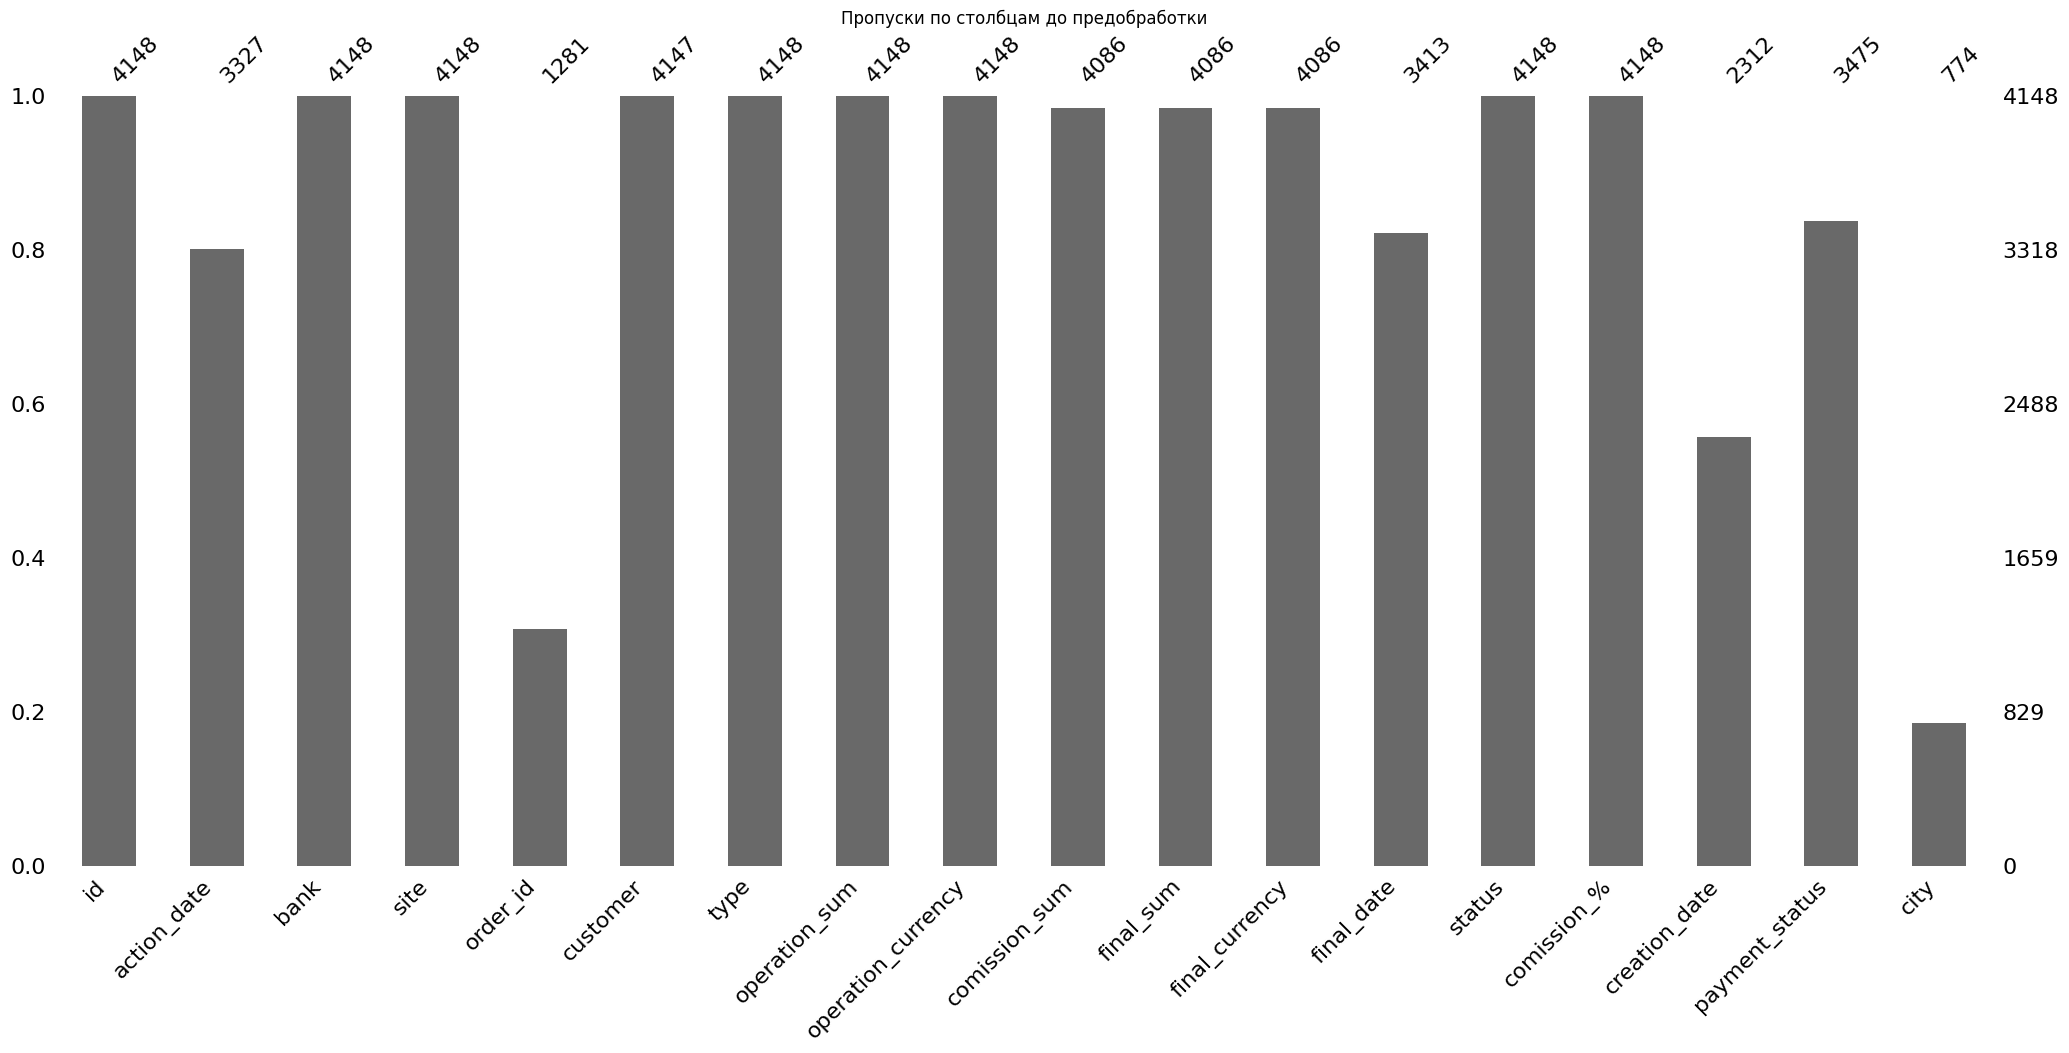

In [21]:
msno.bar(data)
plt.title('Пропуски по столбцам до предобработки')
plt.show()

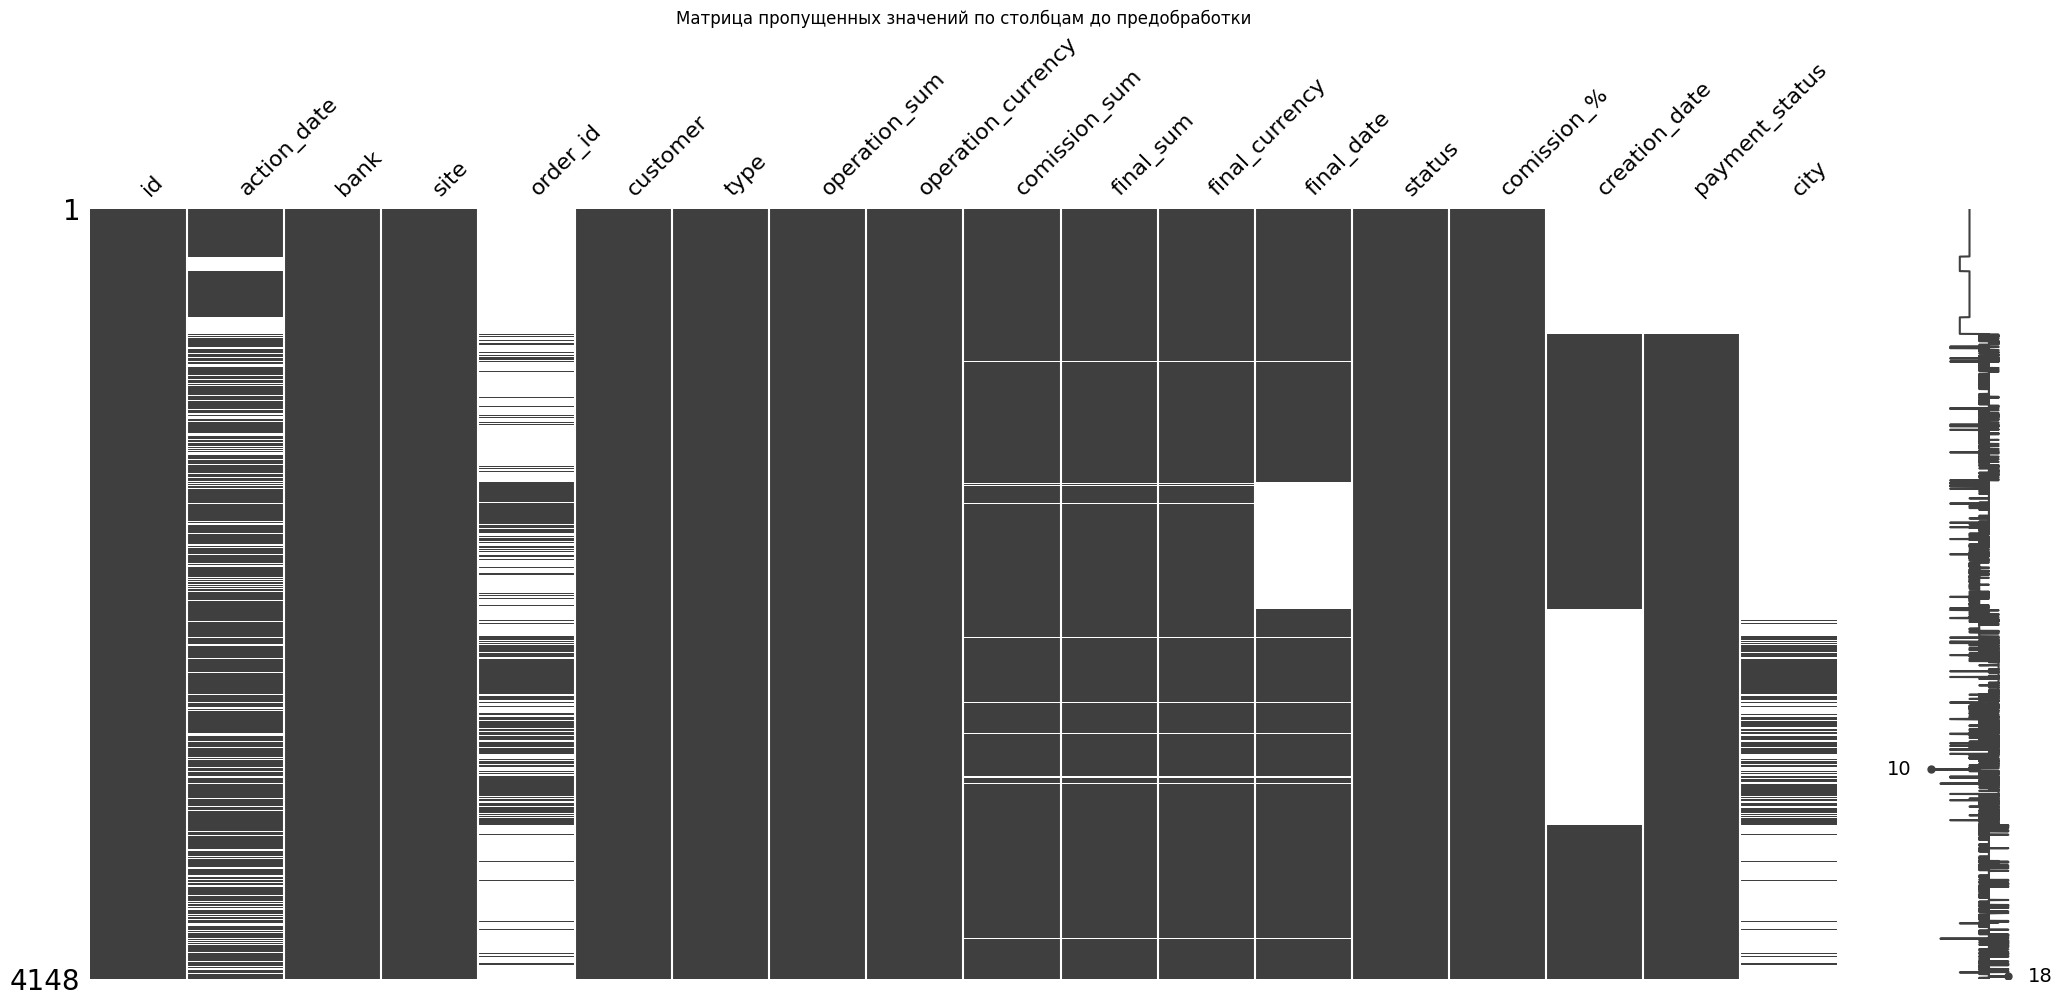

In [22]:
msno.matrix(data)
plt.title('Матрица пропущенных значений по столбцам до предобработки')
plt.show()

У нас нет группы данных в столбцах **final_date и creation_date**, скорее всего это данные полностью по месяцам.

In [23]:
list_gaps = data.isna().sum()[data.isna().sum() > 0].index.to_list()
list_gaps

['action_date',
 'order_id',
 'customer',
 'comission_sum',
 'final_sum',
 'final_currency',
 'final_date',
 'creation_date',
 'payment_status',
 'city']

In [24]:
data[list_gaps].isnull().corr()

,action_date,order_id,customer,comission_sum,final_sum,final_currency,final_date,creation_date,payment_status,city
action_date,1.000000,0.182753,-0.007714,0.247971,0.247971,0.247971,0.051538,-0.052861,0.058747,0.135422
order_id,0.182753,1.000000,0.010380,-0.175683,-0.175683,-0.175683,-0.217308,-0.177544,0.294165,0.712517
customer,-0.007714,0.010380,1.000000,-0.001913,-0.001913,-0.001913,-0.007206,-0.013838,-0.006834,0.007438
comission_sum,0.247971,-0.175683,-0.001913,1.000000,1.000000,1.000000,0.265443,0.014230,-0.054210,-0.104194
final_sum,0.247971,-0.175683,-0.001913,1.000000,1.000000,1.000000,0.265443,0.014230,-0.054210,-0.104194
final_currency,0.247971,-0.175683,-0.001913,1.000000,1.000000,1.000000,0.265443,0.014230,-0.054210,-0.104194
final_date,0.051538,-0.217308,-0.007206,0.265443,0.265443,0.265443,1.000000,-0.374135,-0.204223,0.170406
creation_date,-0.052861,-0.177544,-0.013838,0.014230,0.014230,0.014230,-0.374135,1.000000,0.493842,-0.442787
payment_status,0.058747,0.294165,-0.006834,-0.054210,-0.054210,-0.054210,-0.204223,0.493842,1.000000,0.210779
city,0.135422,0.712517,0.007438,-0.104194,-0.104194,-0.104194,0.170406,-0.442787,0.210779,1.000000


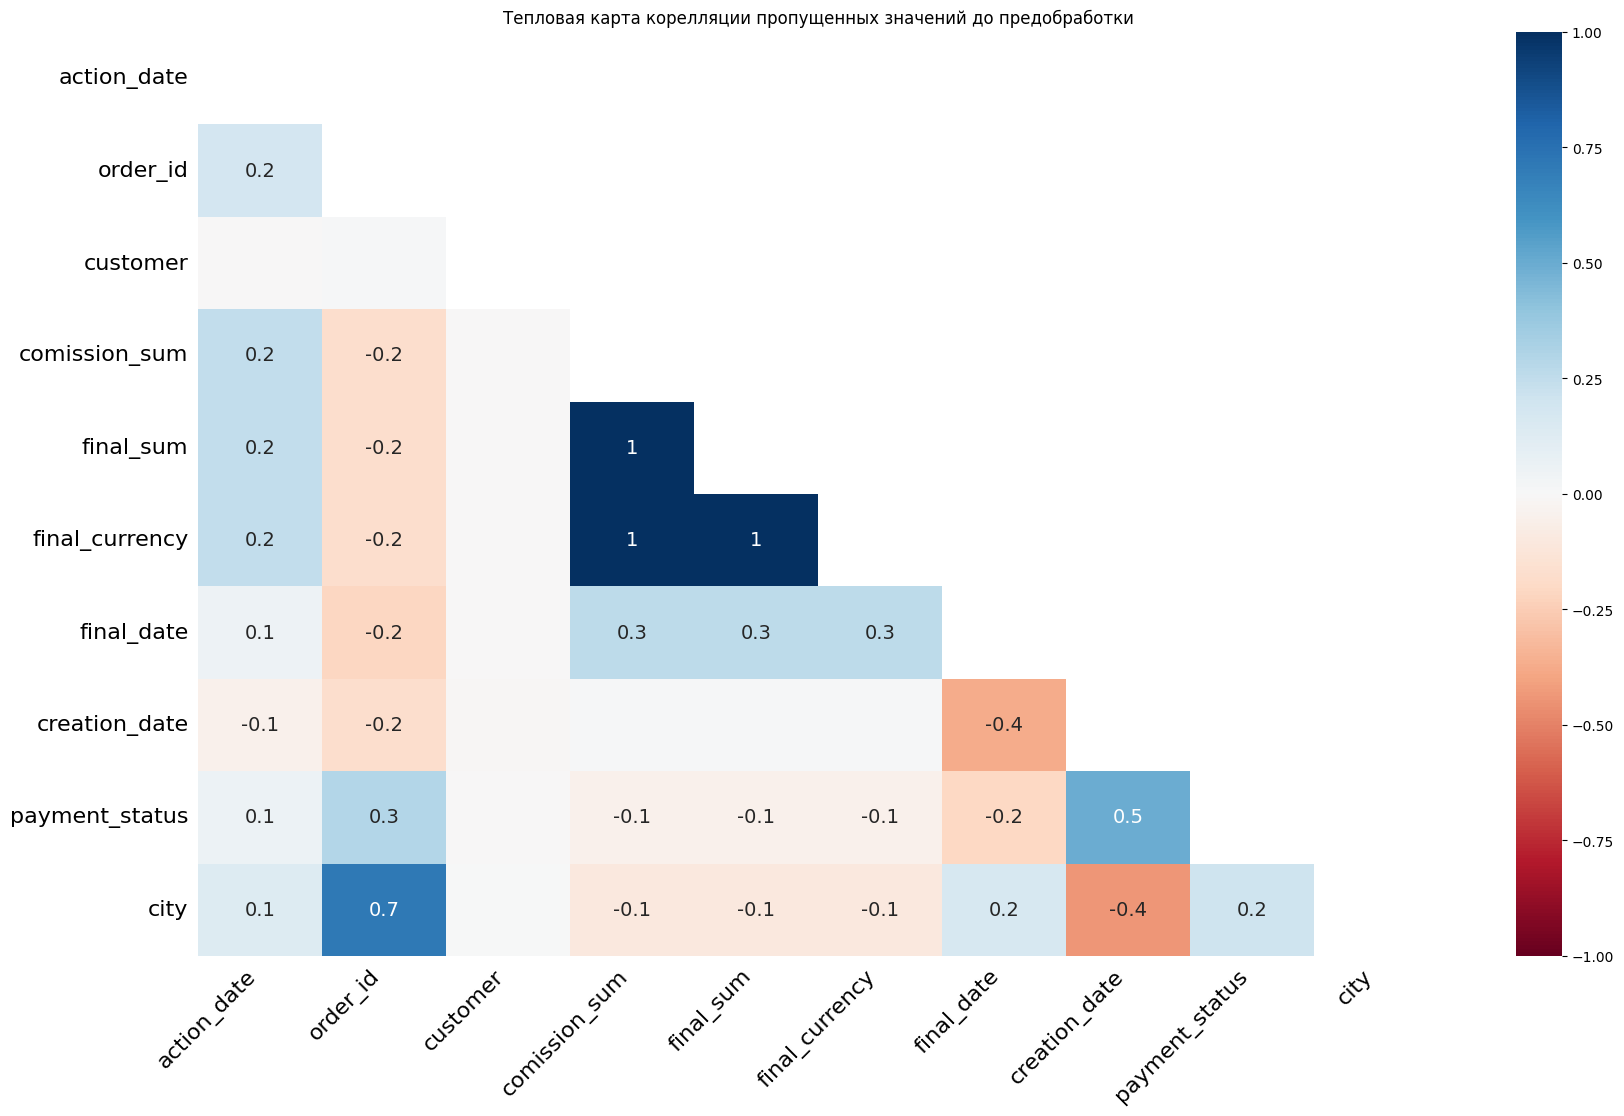

In [25]:
msno.heatmap(data)
plt.title('Тепловая карта корелляции пропущенных значений до предобработки')
plt.show()

В нашем случае пропуски у столбцов **final_sum,	final_currency и comission_sum** полностью связаны между собой. Также есть положительная корреляция пропусков между полями **city и order_id**.

#### Пропуски в датах

По матрице пропущенных значений видно, что пропуски в столбце **final_date** расположены вместе, скорей всего это один период времени. Оценим период и попробуем заполнить пропуски в столбце **action_date**.

In [26]:
data.loc[data['final_date'].isna()]['action_date'].describe()

,action_date
count,557
mean,2024-05-21 05:07:23.806104064
min,2024-05-01 09:55:00
25%,2024-05-13 14:15:00
50%,2024-05-25 09:47:00
75%,2024-05-28 10:22:00
max,2024-05-31 21:46:00


In [27]:
data.loc[data['creation_date'].isna()]['action_date'].describe()

,action_date
count,1516
mean,2024-05-01 10:20:35.817942016
min,2024-01-01 09:55:00
25%,2024-02-13 14:50:15
50%,2024-06-09 17:27:00
75%,2024-06-22 10:46:30
max,2024-06-30 22:18:00


In [28]:
data.loc[data['action_date'].isna()]['creation_date'].describe()

,creation_date
count,501
mean,2024-05-19 00:27:16.407185664
min,2024-03-01 01:28:00
25%,2024-04-12 20:27:00
50%,2024-05-13 08:56:00
75%,2024-07-11 01:24:00
max,2024-07-31 15:20:00


Пропуски в столбце **final_date** только в мае.
Пропуски в **creation_date** в разные периоды.


Посмотрим какая разница во времени между **creation_date и action_date**

In [29]:
data['diff_days'] = (data['action_date'] - data['creation_date'].dt.floor('D')).dt.days
data.head()

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,final_date,status,comission_%,creation_date,payment_status,city,diff_days
0,2080468405,2024-01-31 20:18:00,Тинькофф,prostieveschi.ru,NaN,12ost****@mail.ru,Регулярная оплата,1000,RUB,32.0,968.0,RUB,2024-02-01,Завершена,3.2,NaT,NaN,NaN,NaN
1,2080039460,2024-01-30 22:18:00,Тинькофф,prostieveschi.ru,NaN,tigro****@gmail.com,Регулярная оплата,200,RUB,6.4,193.6,RUB,2024-01-31,Завершена,3.2,NaT,NaN,NaN,NaN
2,2079851261,2024-01-30 14:55:00,Тинькофф,prostieveschi.ru,NaN,nat****@gmail.com,Регулярная оплата,300,RUB,9.6,290.4,RUB,2024-01-31,Завершена,3.2,NaT,NaN,NaN,NaN
3,2079846986,2024-01-30 14:45:00,Тинькофф,prostieveschi.ru,NaN,natalk****@inbox.ru,Регулярная оплата,700,RUB,22.4,677.6,RUB,2024-01-31,Завершена,3.2,NaT,NaN,NaN,NaN
4,2079829457,2024-01-30 14:09:00,Тинькофф,prostieveschi.ru,NaN,in****@yandex.ru,Регулярная оплата,500,RUB,16.0,484.0,RUB,2024-01-31,Завершена,3.2,NaT,NaN,NaN,NaN


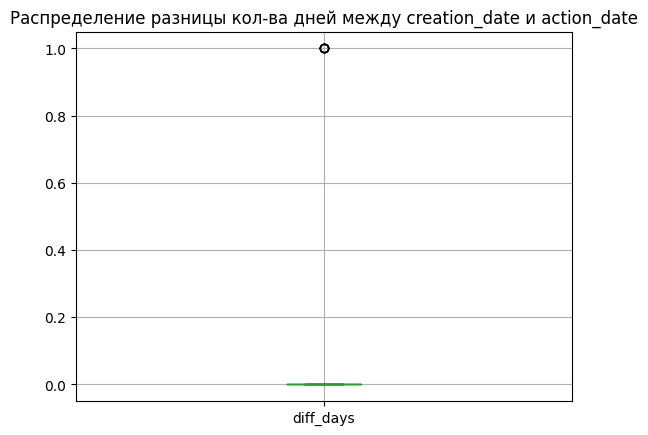

In [30]:
data[['id','diff_days']].boxplot()
plt.title('Распределение разницы кол-ва дней между creation_date и action_date')
plt.show()

In [31]:
data['diff_days'].mean()

0.0027609055770292656

In [32]:
data.loc[data['diff_days']>0]

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,final_date,status,comission_%,creation_date,payment_status,city,diff_days
1534,2116705095,2024-05-30 00:04:00,Тинькофф,prostieveschi.ru,21321.0,nchuis****@gmail.com,Оплата с созданием подписки,1000,RUB,32.0,968.0,RUB,NaT,Completed,3.2,2024-05-29 23:59:00,Approved,NaN,1.0
1657,2116362990,2024-05-28 01:24:00,Тинькофф,prostieveschi.ru,21185.0,Rja****@mail.ru,Оплата,500,RUB,16.0,484.0,RUB,NaT,Completed,3.2,2024-05-27 23:10:00,Approved,NaN,1.0
3965,2123124948,2024-07-07 00:04:00,Тинькофф,prostieveschi.ru,NaN,O****@mail.ru,Регулярная оплата,100,RUB,3.9,96.1,RUB,2024-07-08,Completed,3.2,2024-07-06 23:59:00,Approved,NaN,1.0
3981,2122965623,2024-07-06 00:04:00,Тинькофф,prostieveschi.ru,NaN,ivanova.tanya****@gmail.com,Регулярная оплата,300,RUB,9.6,290.4,RUB,2024-07-08,Completed,3.2,2024-07-05 23:59:00,Approved,NaN,1.0
4002,2122793309,2024-07-05 00:04:00,Тинькофф,prostieveschi.ru,NaN,Akka****@gmail.com,Регулярная оплата,300,RUB,9.6,290.4,RUB,2024-07-08,Completed,3.2,2024-07-04 23:59:00,Approved,NaN,1.0


In [33]:
median_diff_days = data['diff_days'].median()
median_diff_days

0.0

У нас есть случаи, когда разница между creation_date и action_date составила 1 день, но это случаи, когда совершение платежа пришлось в момент перехода дня, **по сути у нас нет разницы в днях в этих столбцах**.

**Учитывая это дозаполним пропуски в action_date значениями из столбца creation_date**

In [34]:
#Перезапишем данные в новый датафрейм
new_df = data.copy(deep=True)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4148 entries, 0 to 4147
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  4148 non-null   object        
 1   action_date         3327 non-null   datetime64[ns]
 2   bank                4148 non-null   object        
 3   site                4148 non-null   object        
 4   order_id            1281 non-null   object        
 5   customer            4147 non-null   object        
 6   type                4148 non-null   object        
 7   operation_sum       4148 non-null   int64         
 8   operation_currency  4148 non-null   object        
 9   comission_sum       4086 non-null   float64       
 10  final_sum           4086 non-null   float64       
 11  final_currency      4086 non-null   object        
 12  final_date          3413 non-null   datetime64[ns]
 13  status              4148 non-null   object      

In [35]:
#Заполним пропуски в action_date значениями из creation_date
new_df['action_date'] = new_df['action_date'].fillna(data['creation_date'])

In [36]:
#Количество пропусков после заполнения
new_df['action_date'].isna().sum()

320

In [37]:
#Посмотрим по каким месяцам остались пропуски
new_df.loc[new_df['action_date'].isna()].groupby(new_df['final_date'].dt.to_period('M'))['id'].count()

,id
final_date,
2024-01,78
2024-02,90
2024-03,1
2024-06,110
2024-07,10


In [38]:
#Посмотрим с каким статусов проходят заявки, где есть пропуски в датах
new_df.query('action_date.isna()').groupby('status', as_index=False)['id'].count()

,status,id
0,Declined,151
1,Отклонена,169


In [39]:
#Всего значений в столбце статус
new_df.value_counts('status')

,count
status,
Completed,2823
Declined,652
Завершена,504
Отклонена,169


Итого нам удалось заполнить чуть более 500 пропусков. Пропуски остались только в столбцах со статусом оплата отклонена.
Посмотрим разницу в днях со столбцом final_date.

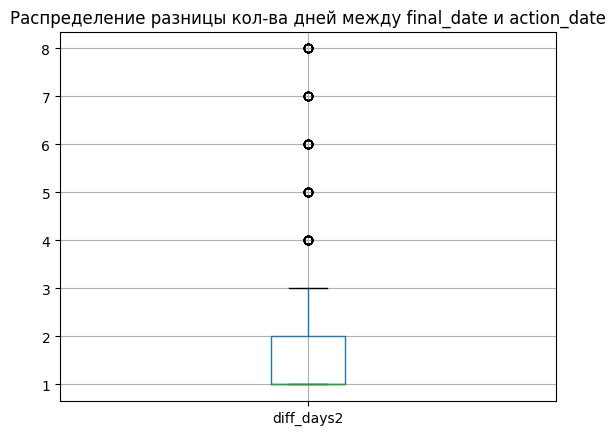

In [40]:
new_df['diff_days2'] = (new_df['final_date'] - new_df['action_date'].dt.floor('D')).dt.days


new_df[['id','diff_days2']].boxplot()
plt.title('Распределение разницы кол-ва дней между final_date и action_date')
plt.show()

In [41]:
new_df['diff_days2'].mean()

1.557618437900128

In [42]:
new_df['diff_days2'].median()

1.0

Здесь разница в среднем 1,5 дня, медианные значения дают 1 день, это значит, что при проведении операции, дата операции в столбце final_date прописывается на 1-2 дня позже.
Этим значением мы можем заполнить пропуски в action_date.

In [43]:
new_df['action_date'] = new_df['action_date'].fillna(new_df['final_date'] - pd.to_timedelta(new_df['diff_days2'].median(), unit='D'))

In [44]:
new_df['action_date'].isna().sum()

31

Итого мы восстановили почти все значения дат.

####Пропуски в order_id

Теперь оценим пропуски в номерах заказах. Посмотрим есть ли связь с другими полями.

In [45]:
#Распределение значений по типам платежей
new_df.value_counts('type')

,count
type,
Регулярная оплата,2858
Оплата,836
Оплата с созданием подписки,454


In [46]:
#Распределение значений по типам платежей, где есть пропуски в столбце order_id
new_df.query('order_id.isna()').groupby('type')['id'].count()

,id
type,
Оплата с созданием подписки,9
Регулярная оплата,2858


In [47]:
new_df.query('order_id.isna()').groupby('type')['id'].count() / new_df.value_counts('type')

,0
type,
Оплата,NaN
Оплата с созданием подписки,0.019824
Регулярная оплата,1.000000


Да, мы можем подтвердить, что у типа оплаты **Регулярная оплата** 100% не заполнено поле order_id.

Также есть 9 пропусков при типе **Оплата с созданием подписки**. Заполнем пропуски маркерным значением.

In [48]:
new_df.query('order_id.isna() and type =="Оплата с созданием подписки"')

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,final_date,status,comission_%,creation_date,payment_status,city,diff_days,diff_days2
40,2076897932,2024-01-24 11:35:00,Тинькофф,prostieveschi.ru,NaN,k1rr****@gmail.com,Оплата с созданием подписки,500,RUB,16.0,484.0,RUB,2024-01-25,Завершена,3.2,NaT,NaN,NaN,NaN,1.0
205,2068973025,2024-01-06 21:04:00,Тинькофф,prostieveschi.ru,NaN,reasontosta****@gmail.com,Оплата с созданием подписки,300,RUB,9.6,290.4,RUB,2024-01-09,Завершена,3.2,NaT,NaN,NaN,NaN,3.0
515,2085227563,2024-02-10 17:42:00,Тинькофф,prostieveschi.ru,NaN,kgpozdny****@gmail.com,Оплата с созданием подписки,2000,RUB,64.0,1936.0,RUB,2024-02-12,Завершена,3.2,NaT,NaN,NaN,NaN,2.0
747,2102683701,2024-03-24 07:25:00,Тинькофф,prostieveschi.ru,NaN,ksebondar****@gmail.com,Оплата с созданием подписки,500,RUB,16.0,484.0,RUB,2024-03-25,Completed,3.2,2024-03-24 07:24:00,Approved,NaN,0.0,1.0
983,2097951277,2024-03-10 12:21:00,Тинькофф,prostieveschi.ru,NaN,blackberryk****@gmail.com,Оплата с созданием подписки,100,RUB,3.9,96.1,RUB,2024-03-11,Completed,3.2,2024-03-10 12:21:00,Approved,NaN,0.0,1.0
3511,2126142674,2024-07-25 17:26:00,Тинькофф,prostieveschi.ru,NaN,grushina****@yandex.ru,Оплата с созданием подписки,200,RUB,6.4,193.6,RUB,2024-07-26,Completed,3.2,2024-07-25 17:26:00,Approved,Москва,0.0,1.0
3528,2126012257,2024-07-24 21:52:00,Тинькофф,prostieveschi.ru,NaN,nellyakov****@yandex.ru,Оплата с созданием подписки,500,RUB,16.0,484.0,RUB,2024-07-25,Completed,3.2,2024-07-24 21:51:00,Approved,Санкт-Петербург,0.0,1.0
3936,2123501207,2024-07-09 09:17:00,Тинькофф,prostieveschi.ru,NaN,irina.sasch****@yandex.ru,Оплата с созданием подписки,1000,RUB,32.0,968.0,RUB,2024-07-10,Completed,3.2,2024-07-09 09:16:00,Approved,NaN,0.0,1.0
4079,2122422659,2024-07-02 20:42:00,Тинькофф,prostieveschi.ru,NaN,ira-ira-gu****@list.ru,Оплата с созданием подписки,300,RUB,9.6,290.4,RUB,2024-07-03,Completed,3.2,2024-07-02 20:42:00,Approved,NaN,0.0,1.0


In [49]:
new_df['order_id'].describe()

,order_id
count,1281.0
unique,1223.0
top,3058309.0
freq,5.0


In [50]:
new_df['order_id'] = new_df['order_id'].fillna(999999999)

<ipython-input-50-09b56ae15eb3>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df['order_id'] = new_df['order_id'].fillna(999999999)


In [51]:
new_df['order_id'].isna().sum()

0

####Пропуски в comission_sum, final_sum и final_curerncy

Пропуски в этих столбцах в одних и тех же строках. Посмотрим есть ли зависимость пропуска от значений другого столбца.

In [52]:
new_df.query('comission_sum.isna()').value_counts('status')

,count
status,
Declined,62


In [53]:
new_df.value_counts('status')

,count
status,
Completed,2823
Declined,652
Завершена,504
Отклонена,169


In [54]:
new_df.query('comission_sum.isna()').head()

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,final_date,status,comission_%,creation_date,payment_status,city,diff_days,diff_days2
741,2102818252,2024-03-24 16:40:00,Тинькофф,prostieveschi.ru,31510123.0,****@mail.ru,Оплата,200,RUB,NaN,NaN,NaN,NaT,Declined,0.0,2024-03-24 16:40:00,CheckResponseServiceUnavailable,NaN,NaN,NaN
748,2102643971,2024-03-24 01:04:00,Тинькофф,prostieveschi.ru,20049.0,liox****@gmail.com,Оплата,10,EUR,NaN,NaN,NaN,NaT,Declined,0.0,2024-03-24 01:04:00,5113,NaN,NaN,NaN
749,2102643784,2024-03-24 01:03:00,Тинькофф,prostieveschi.ru,20048.0,liox****@gmail.com,Оплата,10,EUR,NaN,NaN,NaN,NaT,Declined,0.0,2024-03-24 01:03:00,5113,NaN,NaN,NaN
804,2101167552,2024-03-19 17:09:00,Тинькофф,prostieveschi.ru,515408499.0,mnaula****@gmail.com,Оплата,3000,RUB,NaN,NaN,NaN,NaT,Declined,0.0,2024-03-19 17:09:00,CheckResponseServiceUnavailable,NaN,NaN,NaN
821,2100792929,2024-03-18 14:07:00,Тинькофф,prostieveschi.ru,19972.0,kliriko****@gmail.com,Оплата,300,RUB,NaN,NaN,NaN,NaT,Declined,0.0,2024-03-18 14:07:00,5113,NaN,NaN,NaN


In [55]:
#Посмотрим по каким месяцам пропуски
new_df.loc[new_df['comission_sum'].isna()].groupby(new_df['action_date'].dt.to_period('M'))['id'].count()

,id
action_date,
2024-03,6
2024-04,6
2024-05,15
2024-07,4


In [56]:
#Посмотрим по каким валютам пропуски
new_df.query('comission_sum.isna()').value_counts('operation_currency')

,count
operation_currency,
RUB,36
EUR,15
USD,7
BYN,4


In [57]:
new_df.value_counts('operation_currency')

,count
operation_currency,
RUB,4122
EUR,15
USD,7
BYN,4


In [58]:
new_df.value_counts('final_currency')

,count
final_currency,
RUB,4086


In [59]:
#Посмотрим по статусам платежей пропуски
new_df.query('comission_sum.isna()').value_counts('payment_status')

,count
payment_status,
5113,26
AuthenticationFailed,12
UnableToProcess,10
CheckResponseFormatError,8
CheckResponseServiceUnavailable,6


Возможно пропуски/ отмены платежей могли случится в том числе из-за валюты платежей пропуски в столбцах **comission_sum, final_sum и final_curerncy** 100% связаны с валютой платежа, ни один платеж в другой валюте не прошел. Также есть не прошедшие платежи в рублях.

Оценим суммы по этим столбцам. Сохраним в отдельный датафрейм и исключим эти данные из текущего датафрейма.

In [60]:
#Сохраним эти данный в отдельный датафрейм
payments_in_cur = new_df.query('comission_sum.isna()')[['id', 'action_date', 'bank', 'site', 'status', 'order_id', 'customer',
                                                   'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum',
                                                   'final_currency', 'comission_%', 'city', 'payment_status', 'creation_date']]
payments_in_cur.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, 741 to 4111
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  62 non-null     object        
 1   action_date         31 non-null     datetime64[ns]
 2   bank                62 non-null     object        
 3   site                62 non-null     object        
 4   status              62 non-null     object        
 5   order_id            62 non-null     float64       
 6   customer            62 non-null     object        
 7   type                62 non-null     object        
 8   operation_sum       62 non-null     int64         
 9   operation_currency  62 non-null     object        
 10  comission_sum       0 non-null      float64       
 11  final_sum           0 non-null      float64       
 12  final_currency      0 non-null      object        
 13  comission_%         62 non-null     float64       
 1

In [61]:
#Посмотрим сразу здесь дубликаты сумм
payments_in_cur[payments_in_cur.duplicated(subset=['customer', 'creation_date', 'operation_sum'], keep=False)]

,id,action_date,bank,site,status,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,comission_%,city,payment_status,creation_date
2330,2121371613,NaT,Тинькофф,prostieveschi.ru,Declined,2470947.0,elen.b****@gmail.com,Оплата,500,RUB,NaN,NaN,NaN,0.0,Санкт-Петербург,CheckResponseFormatError,NaT
2331,2121371446,NaT,Тинькофф,prostieveschi.ru,Declined,2470947.0,elen.b****@gmail.com,Оплата,500,RUB,NaN,NaN,NaN,0.0,Санкт-Петербург,CheckResponseFormatError,NaT
2657,2120299673,NaT,Тинькофф,prostieveschi.ru,Declined,22147.0,sod.guseva****@gmail.com,Оплата,500,RUB,NaN,NaN,NaN,3.2,Москва,UnableToProcess,NaT
2658,2120299541,NaT,Тинькофф,prostieveschi.ru,Declined,22147.0,sod.guseva****@gmail.com,Оплата,500,RUB,NaN,NaN,NaN,3.2,Москва,UnableToProcess,NaT
2746,2119581714,NaT,Тинькофф,prostieveschi.ru,Declined,22048.0,marsano****@gmail.com,Оплата,10,BYN,NaN,NaN,NaN,0.0,Москва,5113,NaT
2747,2119581650,NaT,Тинькофф,prostieveschi.ru,Declined,22048.0,marsano****@gmail.com,Оплата,10,BYN,NaN,NaN,NaN,3.9,Москва,UnableToProcess,NaT
2825,2119261603,NaT,Тинькофф,prostieveschi.ru,Declined,3058309.0,fro****@mail.ru,Оплата,55,RUB,NaN,NaN,NaN,0.0,Вена,CheckResponseFormatError,NaT
2826,2119261590,NaT,Тинькофф,prostieveschi.ru,Declined,3058309.0,fro****@mail.ru,Оплата,55,RUB,NaN,NaN,NaN,0.0,Вена,CheckResponseFormatError,NaT
2827,2119261542,NaT,Тинькофф,prostieveschi.ru,Declined,3058309.0,fro****@mail.ru,Оплата,55,RUB,NaN,NaN,NaN,0.0,Вена,CheckResponseFormatError,NaT
3183,2117601693,NaT,Тинькофф,prostieveschi.ru,Declined,21550.0,dmitry@pravdin.org,Оплата,10,EUR,NaN,NaN,NaN,0.0,Никосия,5113,NaT


In [62]:
payments_in_cur = payments_in_cur.drop_duplicates(subset=['customer', 'creation_date', 'operation_sum']).reset_index(drop=True)

payments_in_cur[payments_in_cur.duplicated(subset=['customer', 'creation_date', 'operation_sum'], keep=False)]

,id,action_date,bank,site,status,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,comission_%,city,payment_status,creation_date


In [63]:
payments_in_cur.query('comission_sum.isna()').groupby('operation_currency')['operation_sum'].agg(['count', 'sum', 'mean'])

,count,sum,mean
operation_currency,,,
BYN,3,110,36.666667
EUR,14,184,13.142857
RUB,32,47455,1482.968750
USD,7,343,49.000000


Эти платежи были примерно на сумму 100 000 рублей за наблюдаемый период.

Добавим столбцы с месяцем, датой без времени, и статусом в общем виде и сохраним в файл.

In [64]:
payments_in_cur['month'] =  payments_in_cur['action_date'].dt.to_period('M').astype(str)
payments_in_cur['action_date2'] = pd.to_datetime(new_df['action_date']).dt.date

In [65]:
#Функция, приводящая значения в столбце status к единому виду
def status(col):
  if col == 'Completed' or col == 'Завершена':
    return 'завершена'
  elif col== 'Declined' or col == 'Отклонена':
    return 'отклонена'
  else:
    return 'NaN'

In [66]:
payments_in_cur['status2'] = payments_in_cur['status'].apply(status)

In [67]:
payments_in_cur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  56 non-null     object        
 1   action_date         31 non-null     datetime64[ns]
 2   bank                56 non-null     object        
 3   site                56 non-null     object        
 4   status              56 non-null     object        
 5   order_id            56 non-null     float64       
 6   customer            56 non-null     object        
 7   type                56 non-null     object        
 8   operation_sum       56 non-null     int64         
 9   operation_currency  56 non-null     object        
 10  comission_sum       0 non-null      float64       
 11  final_sum           0 non-null      float64       
 12  final_currency      0 non-null      object        
 13  comission_%         56 non-null     float64       
 

In [68]:
payments_in_cur = payments_in_cur[['id', 'action_date2', 'month', 'bank', 'site', 'order_id', 'customer',
                                                   'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum',
                                                   'final_currency', 'status2', 'comission_%', 'city', 'payment_status']]

In [69]:
#сохраняем в файл
payments_in_cur.to_excel('payments_in_cur.xlsx', index=False)

In [70]:
# Зафиксируем количество строк до удаления
shape = new_df.shape[0]
shape

4148

In [71]:
new_df.dropna(subset='comission_sum', inplace=True, ignore_index=True)

In [72]:
print(f'Удалено строк: {round((1 -new_df.shape[0] / shape) *100, 2)}%')
print()
display(new_df.isna().sum())

Удалено строк: 1.49%



,0
id,0
action_date,0
bank,0
site,0
order_id,0
customer,1
type,0
operation_sum,0
operation_currency,0
comission_sum,0


In [73]:
new_df.groupby('operation_currency')['operation_sum'].count()

,operation_sum
operation_currency,
RUB,4086


####Пропуски в столбце customer

In [74]:
new_df.query('customer.isna()')

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,final_date,status,comission_%,creation_date,payment_status,city,diff_days,diff_days2
1000,2096037273,2024-03-05 13:58:00,Тинькофф,prostieveschi.ru,999999999.0,NaN,Регулярная оплата,100,RUB,3.9,96.1,RUB,2024-03-06,Completed,3.2,2024-03-05 13:58:00,Approved,NaN,0.0,1.0


Так как для анализа и дальнейших рекламных действий нам необходим ID клиента, эту строку мы удалим.

In [75]:
new_df.shape[0]

4086

In [76]:
new_df = new_df.dropna(subset='customer').reset_index(drop=True)

In [77]:
new_df.shape[0]

4085

####Пропуски в столбце city

In [78]:
new_df.query('city.isna()').value_counts('type')

,count
type,
Регулярная оплата,2854
Оплата,319
Оплата с созданием подписки,170


In [79]:
new_df.query('city.isna()').value_counts('status')

,count
status,
Completed,2114
Declined,556
Завершена,504
Отклонена,169


In [80]:
new_df.loc[new_df['city'].isna()].groupby(new_df['action_date'].dt.to_period('M'))['id'].count()

,id
action_date,
2024-01,335
2024-02,338
2024-03,394
2024-04,388
2024-05,673
2024-06,463
2024-07,752


По столбцу город не видно зависимости незаполнения платежа ни от столбца статус, ни от типа, ни от даты. В этом столбце пропуски мы оставим.

#### Пропуски в столбце **payment_status**

Добавим сотлбец с месяцем посмотрим по каким месяцам пропуски

In [81]:
new_df['payment_status'].isna().sum()

673

In [82]:
new_df['month'] = new_df['action_date'].dt.to_period('M').astype(str)

In [83]:
new_df.head()

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,...,final_currency,final_date,status,comission_%,creation_date,payment_status,city,diff_days,diff_days2,month
0,2080468405,2024-01-31 20:18:00,Тинькофф,prostieveschi.ru,999999999.0,12ost****@mail.ru,Регулярная оплата,1000,RUB,32.0,...,RUB,2024-02-01,Завершена,3.2,NaT,NaN,NaN,NaN,1.0,2024-01
1,2080039460,2024-01-30 22:18:00,Тинькофф,prostieveschi.ru,999999999.0,tigro****@gmail.com,Регулярная оплата,200,RUB,6.4,...,RUB,2024-01-31,Завершена,3.2,NaT,NaN,NaN,NaN,1.0,2024-01
2,2079851261,2024-01-30 14:55:00,Тинькофф,prostieveschi.ru,999999999.0,nat****@gmail.com,Регулярная оплата,300,RUB,9.6,...,RUB,2024-01-31,Завершена,3.2,NaT,NaN,NaN,NaN,1.0,2024-01
3,2079846986,2024-01-30 14:45:00,Тинькофф,prostieveschi.ru,999999999.0,natalk****@inbox.ru,Регулярная оплата,700,RUB,22.4,...,RUB,2024-01-31,Завершена,3.2,NaT,NaN,NaN,NaN,1.0,2024-01
4,2079829457,2024-01-30 14:09:00,Тинькофф,prostieveschi.ru,999999999.0,in****@yandex.ru,Регулярная оплата,500,RUB,16.0,...,RUB,2024-01-31,Завершена,3.2,NaT,NaN,NaN,NaN,1.0,2024-01


In [84]:
new_df.columns

Index(['id', 'action_date', 'bank', 'site', 'order_id', 'customer', 'type',
       'operation_sum', 'operation_currency', 'comission_sum', 'final_sum',
       'final_currency', 'final_date', 'status', 'comission_%',
       'creation_date', 'payment_status', 'city', 'diff_days', 'diff_days2',
       'month'],
      dtype='object')

In [85]:
#Посмотрим по каким месяцам пропуски

new_df.loc[new_df['payment_status'].isna()].value_counts('month').sort_index()

,count
month,
2024-01,335
2024-02,338


In [86]:
#Для сравнения выведем количество транзакций по каждому месяцу
new_df.value_counts('month').sort_index()

,count
month,
2024-01,335
2024-02,338
2024-03,394
2024-04,388
2024-05,673
2024-06,1132
2024-07,825


Пропуски по статусу платежа у нас 100% в январе и феврале. Их мы удалять не будем

Итоговый результат после обработки пропусков:

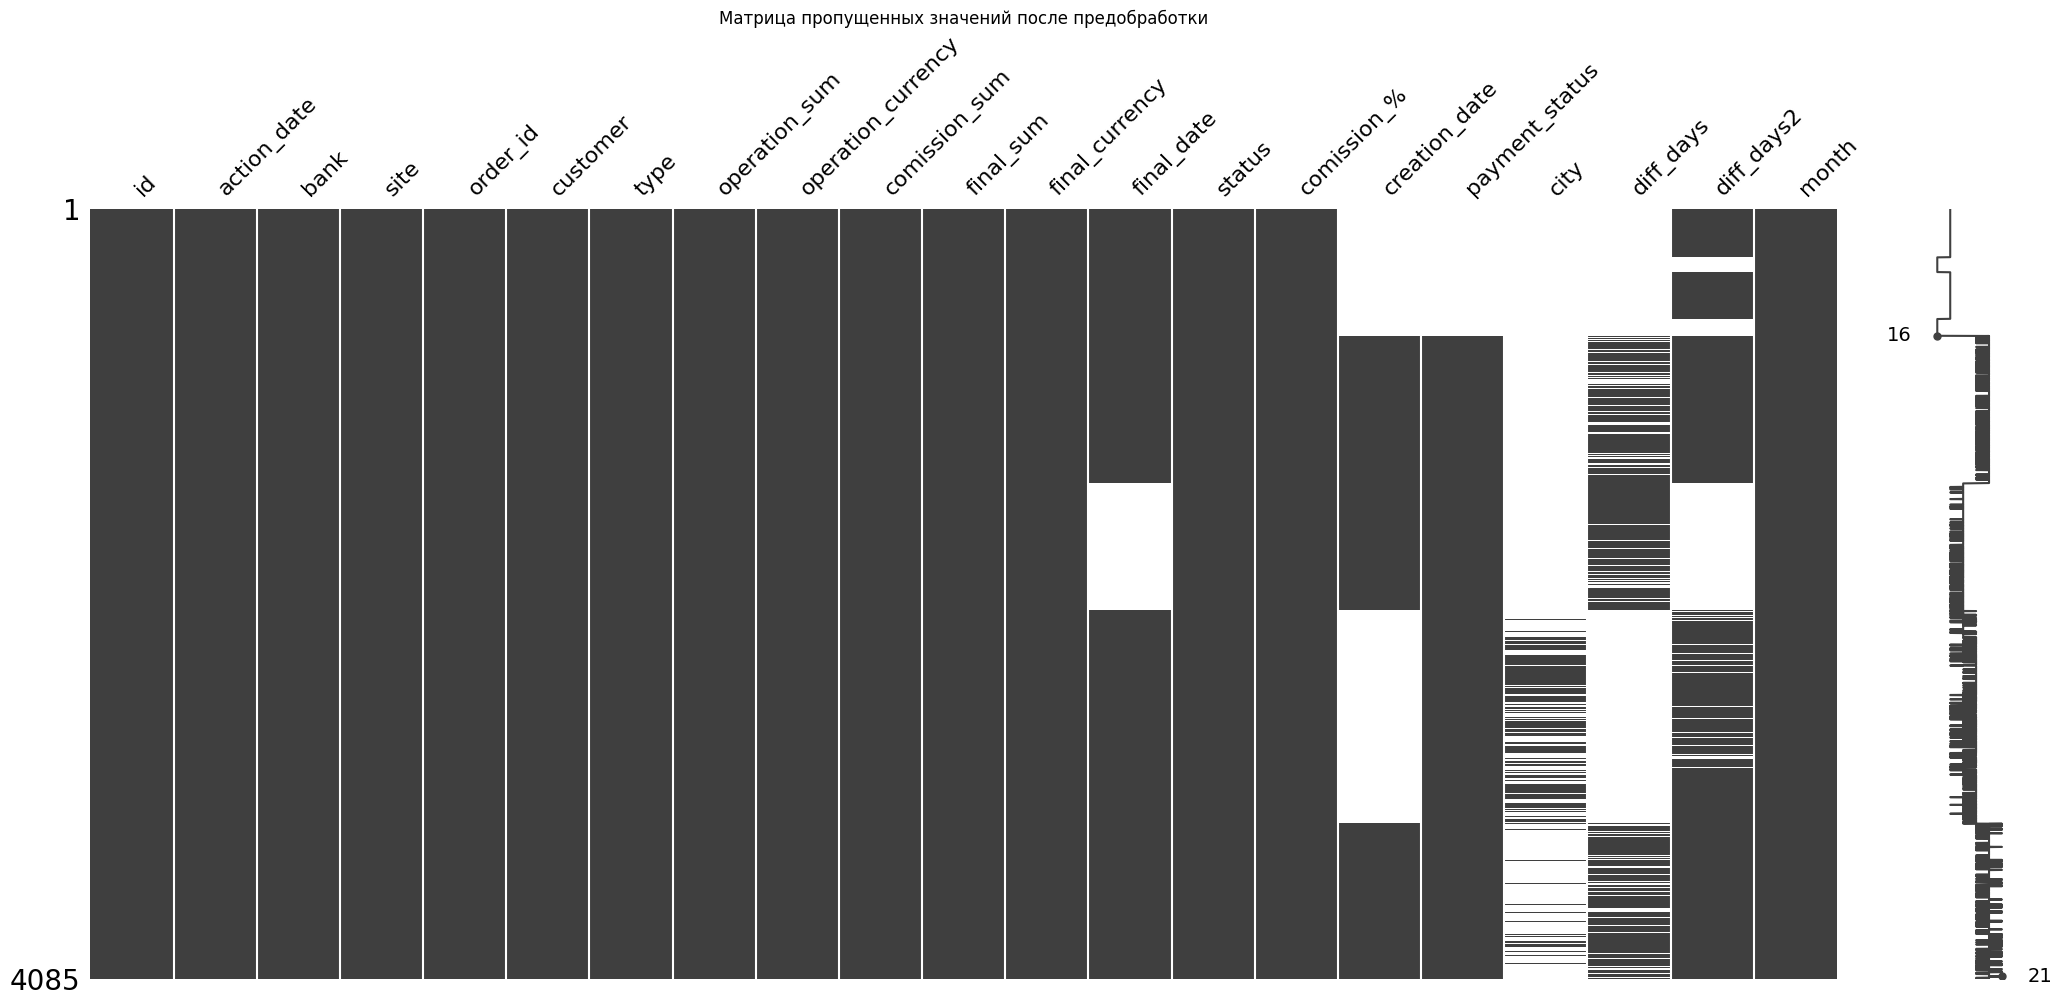

In [87]:
msno.matrix(new_df)
plt.title('Матрица пропущенных значений после предобработки')
plt.show()

###Корректировка данных в столбцах

Переведем значения в столбце **статус (status)** в один вид.

In [88]:
#Текущее распределение значений в столбце
new_df.value_counts('status')

,count
status,
Completed,2822
Declined,590
Завершена,504
Отклонена,169


In [89]:
#Функция, приводящая значения в столбце status к единому виду
def status(col):
  if col == 'Completed' or col == 'Завершена':
    return 'завершена'
  elif col== 'Declined' or col == 'Отклонена':
    return 'отклонена'
  else:
    return 'NaN'

In [90]:
new_df['status2'] = new_df['status'].apply(status)

In [91]:
new_df.value_counts('status2')

,count
status2,
завершена,3326
отклонена,759


Посмотрим другие столбцы

In [92]:
list_check = ['comission_%', 'final_currency', 'operation_currency', 'type', 'site', 'bank', 'city']

for col in list_check:
  print(f'{new_df.value_counts(col)}')
  print()

comission_%
3.2    4085
Name: count, dtype: int64

final_currency
RUB    4085
Name: count, dtype: int64

operation_currency
RUB    4085
Name: count, dtype: int64

type
Регулярная оплата              2855
Оплата                          776
Оплата с созданием подписки     454
Name: count, dtype: int64

site
prostieveschi.ru    4085
Name: count, dtype: int64

bank
Тинькофф    4085
Name: count, dtype: int64

city
Москва             241
Санкт-Петербург    179
Екатеринбург        14
Краснодар           11
Тбилиси              8
                  ... 
Йошкар-Ола           1
Йехуд                1
Иври-сюр-Сен         1
Зеленоград           1
Марибор              1
Name: count, Length: 158, dtype: int64



Здесь изменять значения не нужно.

Посмотрим значения по городам.

In [93]:
sorted(new_df.loc[~new_df['city'].isna()]['city'].unique())

['Ada',
 'Galliate',
 'Kwai Chung',
 'North Bergen',
 'Petah Tikva',
 'Sint Philipsland',
 'Алматы',
 'Альтусрид',
 'Амстердам',
 'Анкара',
 'Апатиты',
 'Архангельск',
 'Афины',
 'Балашиха',
 'Барнаул',
 'Барселона',
 'Бейоглу',
 'Белгород',
 'Белград',
 'Бердск',
 'Берлин',
 'Бирмингем',
 'Бишкек',
 'Бодрум',
 'Будва',
 'Буэнос-Айрес',
 'Варшава',
 'Великий Новгород',
 'Вена',
 'Вила-Реал',
 'Вильнюс',
 'Владивосток',
 'Владимир',
 'Вологда',
 'Воронеж',
 'Геленджик',
 'Горно-Алтайск',
 'Гравлин',
 'Гунценхаузен',
 'Дзержинск',
 'Дмитров',
 'Дорнбирн',
 'Дубай',
 'Екатеринбург',
 'Ереван',
 'Жамберк',
 'Жуковский',
 'Зеленоград',
 'Иваново',
 'Иври-сюр-Сен',
 'Иерусалим',
 'Ижевск',
 'Йехуд',
 'Йошкар-Ола',
 'Казань',
 'Калуга',
 'Кинешма',
 'Киров',
 'Кирово-Чепецк',
 'Кисловодск',
 'Коломна',
 'Колпино',
 'Кондопога',
 'Котор',
 'Краснодар',
 'Кубинка',
 'Курск',
 'Кёльн',
 'Лас-Пальмас-де-Гран-Канария',
 'Лейпциг',
 'Липецк',
 'Лиссабон',
 'Лонг-Бич',
 'Лондон',
 'Лос-Анджелес',
 '

In [94]:
unique_cities = new_df.loc[~new_df['city'].isna(), 'city']
found = False

"""
    Код выичисляет расстояния Левенштейна и выводит
    совпадения на 99% и более
"""

for city, city1 in enumerate(unique_cities.unique()):
    if (unique_cities.nunique()-1) != city:
      for city2 in unique_cities.unique()[(city+1):]:
        if fuzz.ratio(city1, city2) >= 99:

          print(city1)
          print(city2)
          print(50*'-')
          found = True

if not found:
  print('Совпадений не найдено.')

Совпадений не найдено.


###Проверка на наличие дубликатов

In [95]:
#Оценим явные дубликаты
new_df.duplicated().sum()

0

In [96]:
new_df[new_df.duplicated(subset=['id'], keep=False)]

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,...,final_date,status,comission_%,creation_date,payment_status,city,diff_days,diff_days2,month,status2


Посмотрим на повторяющиеся зачения в связке день - клиент. Для этого добавим столбец action_date без времени.

In [97]:
new_df['action_date2'] = pd.to_datetime(new_df['action_date']).dt.date

In [98]:
new_df[new_df.duplicated(subset=['customer', 'action_date2'], keep=False)].sort_values(by='customer').head()

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,...,status,comission_%,creation_date,payment_status,city,diff_days,diff_days2,month,status2,action_date2
1541,2116632146,2024-05-29 15:18:00,Тинькофф,prostieveschi.ru,21287.0,****@mail.ru,Оплата с созданием подписки,100,RUB,3.9,...,Completed,3.2,2024-05-29 15:17:00,Approved,NaN,0.0,NaN,2024-05,завершена,2024-05-29
1527,2116681200,2024-05-29 20:21:00,Тинькофф,prostieveschi.ru,21308.0,****@mail.ru,Оплата,1000,RUB,32.0,...,Completed,3.2,2024-05-29 20:21:00,Approved,NaN,0.0,NaN,2024-05,завершена,2024-05-29
305,2071751869,2024-01-14 00:00:00,Тинькофф,prostieveschi.ru,999999999.0,925470602****@gmail.com,Регулярная оплата,100,RUB,0.5,...,Отклонена,3.2,NaT,NaN,NaN,NaN,NaN,2024-01,отклонена,2024-01-14
2901,2118924442,2024-06-12 00:00:00,Тинькофф,prostieveschi.ru,999999999.0,925470602****@gmail.com,Регулярная оплата,100,RUB,0.5,...,Declined,3.2,NaT,ExceedWithdrawalFrequency,NaN,NaN,NaN,2024-06,отклонена,2024-06-12
2946,2118749230,2024-06-12 00:00:00,Тинькофф,prostieveschi.ru,999999999.0,925470602****@gmail.com,Регулярная оплата,100,RUB,0.5,...,Declined,3.2,NaT,ExceedWithdrawalFrequency,NaN,NaN,NaN,2024-06,отклонена,2024-06-12


In [99]:
#Функция, проверяющая наличие дубликатов в выбранных столбцах, и считающая количество этих дубликатов по выбранному полю
def payments_dupl(list_col, col):
  res = new_df[new_df.duplicated(subset=list_col, keep=False)].sort_values(by='customer').value_counts(col)
  return res

In [100]:
list_col=['customer', 'action_date2', 'operation_sum']

payments_dupl(list_col, 'type')

,count
type,
Регулярная оплата,107
Оплата,56
Оплата с созданием подписки,19


In [101]:
payments_dupl(list_col, 'status2')

,count
status2,
отклонена,137
завершена,45


In [102]:
#Платежи клиентов (успешные и нет) задублировавшиеся по соответствующему статусу.
list_col=['customer', 'action_date2', 'operation_sum', 'status2']
payments_dupl(list_col, 'status2')

,count
status2,
отклонена,103
завершена,7


Чаще всего дублируются **отклоненные регулярные оплаты**. Но и завершенные оплаты есть.

In [103]:
#Посмотрим на список клиентов, где в один и тот же день было совершено несколько платежей на одну и ту же сумму, если значения в колонке count > 1, то это успешные двойные платежи,
#если = 1, мы можем предположить, что после отмены, оплата прошла успешно
list_compl_paym = new_df[new_df.duplicated(subset=['customer', 'action_date2', 'operation_sum'], keep=False)].query('status2 =="завершена"').value_counts('customer')
list_compl_paym

,count
customer,
nextl****@mail.ru,4
humblehelptope****@gmail.com,3
And****@yandex.ru,1
mjacov****@gmail.com,1
katya.gerashch****@gmail.com,1
konstanti****@gmail.com,1
kpl****@yandex.ru,1
ksebondar****@gmail.com,1
l_****@mail.ru,1


In [104]:
#Сохраним список клиентов в отдельный датафрейм
email_dupl = list_compl_paym.index.to_list()
email_dupl

['nextl****@mail.ru',
 'humblehelptope****@gmail.com',
 'And****@yandex.ru',
 'mjacov****@gmail.com',
 'katya.gerashch****@gmail.com',
 'konstanti****@gmail.com',
 'kpl****@yandex.ru',
 'ksebondar****@gmail.com',
 'l_****@mail.ru',
 'lenalenova****@gmail.com',
 'mudr****@gmail.com',
 'k1rr****@gmail.com',
 'nellyakov****@yandex.ru',
 'o.rudit****@iqconsultancy.ru',
 'oon****@yandex.ru',
 'piatka****@gmail.com',
 'prosto-****@mail.ru',
 'tasne****@rambler.ru',
 'thrum_sloth0i@icloud.com',
 'katja1985mt@yandex.ru',
 'k.nevaleno****@gmail.com',
 'Decor.bronni****@gmail.com',
 'daria.****@gmail.com',
 'Janne.A****@gmail.com',
 'Kloushantse****@mail.ru',
 'Schapok****@gmail.com',
 'agova@list.ru',
 'ale****@yandex.ru',
 'alina.zlobins****@gmail.com',
 'aminamag@yandex.ru',
 'daxas****@yandex.ru',
 'ira-ira-gu****@list.ru',
 'denisch****@mail.ru',
 'dmali****@gmail.com',
 'domo****@gmail.com',
 'efimka****@mail.ru',
 'gavri****@gmail.com',
 'grushina****@yandex.ru',
 'immo****@yandex.ru',
 '

In [105]:
#Выведем клиентов у которых возможно задублировались успешные платежи
new_df.query('customer ==["nextl****@mail.ru", "humblehelptope****@gmail.com"]')

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,...,status,comission_%,creation_date,payment_status,city,diff_days,diff_days2,month,status2,action_date2
795,2101232539,2024-03-19 20:53:00,Тинькофф,prostieveschi.ru,19994.0,humblehelptope****@gmail.com,Оплата,50000,RUB,1600.0,...,Completed,3.2,2024-03-19 20:53:00,Approved,NaN,0.0,1.0,2024-03,завершена,2024-03-19
796,2101230263,2024-03-19 20:45:00,Тинькофф,prostieveschi.ru,19994.0,humblehelptope****@gmail.com,Оплата,50000,RUB,0.5,...,Declined,3.2,2024-03-19 20:45:00,ExceedWithdrawalFrequency,NaN,NaN,1.0,2024-03,отклонена,2024-03-19
797,2101229295,2024-03-19 20:42:00,Тинькофф,prostieveschi.ru,19993.0,humblehelptope****@gmail.com,Оплата с созданием подписки,50000,RUB,1600.0,...,Completed,3.2,2024-03-19 20:42:00,Approved,NaN,0.0,1.0,2024-03,завершена,2024-03-19
804,2101066181,2024-03-19 11:20:00,Тинькофф,prostieveschi.ru,19985.0,humblehelptope****@gmail.com,Оплата,50000,RUB,1600.0,...,Completed,3.2,2024-03-19 11:20:00,Approved,NaN,0.0,1.0,2024-03,завершена,2024-03-19
1185,2108961119,2024-04-19 20:42:00,Тинькофф,prostieveschi.ru,999999999.0,humblehelptope****@gmail.com,Регулярная оплата,50000,RUB,0.5,...,Declined,3.2,2024-04-19 20:42:00,SuspectedFraudDecline,NaN,NaN,3.0,2024-04,отклонена,2024-04-19
1635,2116363291,2024-05-27 23:14:00,Тинькофф,prostieveschi.ru,21186.0,nextl****@mail.ru,Оплата с созданием подписки,100,RUB,3.9,...,Completed,3.2,2024-05-27 23:14:00,Approved,NaN,0.0,NaN,2024-05,завершена,2024-05-27
2218,2121561487,2024-06-27 23:15:00,Тинькофф,prostieveschi.ru,999999999.0,nextl****@mail.ru,Регулярная оплата,100,RUB,3.9,...,Completed,3.2,NaT,Approved,NaN,NaN,1.0,2024-06,завершена,2024-06-27
2708,2119570888,2024-06-15 21:22:00,Тинькофф,prostieveschi.ru,22045.0,nextl****@mail.ru,Оплата с созданием подписки,100,RUB,3.9,...,Completed,3.2,NaT,Approved,Москва,NaN,2.0,2024-06,завершена,2024-06-15
2727,2119479167,2024-06-15 11:05:00,Тинькофф,prostieveschi.ru,22019.0,nextl****@mail.ru,Оплата с созданием подписки,100,RUB,3.9,...,Completed,3.2,NaT,Approved,Москва,NaN,2.0,2024-06,завершена,2024-06-15
3364,2126526739,2024-07-27 23:15:00,Тинькофф,prostieveschi.ru,999999999.0,nextl****@mail.ru,Регулярная оплата,100,RUB,3.9,...,Completed,3.2,2024-07-27 23:15:00,Approved,NaN,0.0,2.0,2024-07,завершена,2024-07-27


Так как оплаты успешные, их исключать мы не будем, тем более время оплат разное. В первом случае возможно клиент проводил отдельными переводами несколько платежей, во втором случае клиент судя по всему оформил три ежемесячные подписки.

Посмотрим, что по отменненным платежам.

In [106]:
new_df[new_df.duplicated(subset=['customer', 'action_date2', 'operation_sum'], keep=False)].query('status2 =="отклонена"').value_counts('customer')

,count
customer,
ett****@yandex.ru,6
pollygotl****@gmail.com,4
hafiz****@yandex.ru,4
lial****@list.ru,4
marga****@inbox.ru,4
...,...
l_****@mail.ru,1
lenalenova****@gmail.com,1
denisch****@mail.ru,1


In [107]:
new_df.query('customer =="ett****@yandex.ru"').head(10)

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,...,status,comission_%,creation_date,payment_status,city,diff_days,diff_days2,month,status2,action_date2
330,2067914701,2024-01-08 00:00:00,Тинькофф,prostieveschi.ru,999999999.0,ett****@yandex.ru,Регулярная оплата,500,RUB,0.5,...,Отклонена,3.2,NaT,NaN,NaN,NaN,NaN,2024-01,отклонена,2024-01-08
332,2067494163,2024-01-08 00:00:00,Тинькофф,prostieveschi.ru,999999999.0,ett****@yandex.ru,Регулярная оплата,500,RUB,0.5,...,Отклонена,3.2,NaT,NaN,NaN,NaN,NaN,2024-01,отклонена,2024-01-08
333,2067091792,2024-01-08 00:00:00,Тинькофф,prostieveschi.ru,999999999.0,ett****@yandex.ru,Регулярная оплата,500,RUB,0.5,...,Отклонена,3.2,NaT,NaN,NaN,NaN,NaN,2024-01,отклонена,2024-01-08
665,2082212227,2024-02-04 00:00:00,Тинькофф,prostieveschi.ru,999999999.0,ett****@yandex.ru,Регулярная оплата,500,RUB,0.5,...,Отклонена,3.2,NaT,NaN,NaN,NaN,NaN,2024-02,отклонена,2024-02-04
666,2081751926,2024-02-04 00:00:00,Тинькофф,prostieveschi.ru,999999999.0,ett****@yandex.ru,Регулярная оплата,500,RUB,0.5,...,Отклонена,3.2,NaT,NaN,NaN,NaN,NaN,2024-02,отклонена,2024-02-04
669,2081267628,2024-02-04 00:00:00,Тинькофф,prostieveschi.ru,999999999.0,ett****@yandex.ru,Регулярная оплата,500,RUB,0.5,...,Отклонена,3.2,NaT,NaN,NaN,NaN,NaN,2024-02,отклонена,2024-02-04
1043,2094912531,2024-03-02 12:53:00,Тинькофф,prostieveschi.ru,999999999.0,ett****@yandex.ru,Регулярная оплата,500,RUB,16.0,...,Completed,3.2,2024-03-02 12:53:00,Approved,NaN,0.0,2.0,2024-03,завершена,2024-03-02
1435,2105289289,2024-04-02 12:53:00,Тинькофф,prostieveschi.ru,999999999.0,ett****@yandex.ru,Регулярная оплата,500,RUB,16.0,...,Completed,3.2,2024-04-02 12:53:00,Approved,NaN,0.0,1.0,2024-04,завершена,2024-04-02
2073,2111905697,2024-05-04 12:54:00,Тинькофф,prostieveschi.ru,999999999.0,ett****@yandex.ru,Регулярная оплата,500,RUB,0.5,...,Declined,3.2,2024-05-04 12:54:00,InsufficientFunds,NaN,NaN,NaN,2024-05,отклонена,2024-05-04
2096,2111698563,2024-05-03 12:53:00,Тинькофф,prostieveschi.ru,999999999.0,ett****@yandex.ru,Регулярная оплата,500,RUB,0.5,...,Declined,3.2,2024-05-03 12:53:00,InsufficientFunds,NaN,NaN,NaN,2024-05,отклонена,2024-05-03


В данном случае дубликатов отмененных платежей больше, так как попытки списаний проходят три раза в течение 3х дней. Здесь нужно исключать дубликаты в связке месяц-клиент-сумма. Это мы сделаем в отдельном датафрейме.

Но у нас также есть платежи, по которым в один и тот же день прошла отмена и успешный платеж. Посмотрим на эти дубликаты по ранее сохраненным email с успешными платежами и в последствии исключим id этих отклоненных транзакций из списка отмененных платежей.

In [108]:
#Список клиентов с задублировавшимися переводами с обоими статусами в один и тот же день
new_df[new_df.duplicated(subset=['customer', 'action_date2', 'operation_sum'], keep=False)].loc[new_df['customer'].isin(email_dupl)].groupby(['action_date2', 'status2', 'customer'])['id'].count().head(6)

action_date2  status2    customer               
2024-01-24    завершена  k1rr****@gmail.com         1
              отклонена  k1rr****@gmail.com         1
2024-02-11    завершена  Kloushantse****@mail.ru    1
                         domo****@gmail.com         1
              отклонена  Kloushantse****@mail.ru    1
                         domo****@gmail.com         1
Name: id, dtype: int64

In [109]:
#Список транзакций с отмененными платежами при наличии успешных платежей в тот же день
for_declined = new_df[new_df.duplicated(subset=['customer',
                                                'action_date2',
                                                'operation_sum'], keep=False)].loc[(new_df['customer'].isin(email_dupl)) & (new_df['status2']=='отклонена')].sort_values(by='action_date')

display(for_declined.head())
print()
print('Количество транзакций для исключения из declined: ',for_declined.shape[0])

,id,action_date,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,...,status,comission_%,creation_date,payment_status,city,diff_days,diff_days2,month,status2,action_date2
264,2076874516,2024-01-24,Тинькофф,prostieveschi.ru,999999999.0,k1rr****@gmail.com,Регулярная оплата,500,RUB,0.5,...,Отклонена,3.2,NaT,NaN,NaN,NaN,NaN,2024-01,отклонена,2024-01-24
658,2085266717,2024-02-11,Тинькофф,prostieveschi.ru,999999999.0,Kloushantse****@mail.ru,Регулярная оплата,500,RUB,0.5,...,Отклонена,3.2,NaT,NaN,NaN,NaN,NaN,2024-02,отклонена,2024-02-11
660,2085014587,2024-02-11,Тинькофф,prostieveschi.ru,999999999.0,domo****@gmail.com,Регулярная оплата,200,RUB,0.5,...,Отклонена,3.2,NaT,NaN,NaN,NaN,NaN,2024-02,отклонена,2024-02-11
617,2088803879,2024-02-18,Тинькофф,prostieveschi.ru,999999999.0,k.nevaleno****@gmail.com,Регулярная оплата,100,RUB,0.5,...,Отклонена,3.2,NaT,NaN,NaN,NaN,NaN,2024-02,отклонена,2024-02-18
622,2088338739,2024-02-18,Тинькофф,prostieveschi.ru,999999999.0,k.nevaleno****@gmail.com,Регулярная оплата,100,RUB,0.5,...,Отклонена,3.2,NaT,NaN,NaN,NaN,NaN,2024-02,отклонена,2024-02-18



Количество транзакций для исключения из declined:  44


Разделим платежи на два датафрейма: завершенные операции и отклоненные, чтобы отдельно их проанализировать.

###Добавление новых столбцов, разделение датафреймов

In [110]:
declined = new_df[new_df['status2'] == 'отклонена'][['id', 'action_date', 'action_date2', 'month', 'bank', 'site', 'order_id', 'customer',
                                                   'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum',
                                                   'final_currency', 'status2', 'comission_%', 'city', 'payment_status']]

In [111]:
def check_info(df):
  display(df.head())
  print()
  print(df.info())
  print()
  display(df.value_counts('status2'))


In [112]:
check_info(declined)

,id,action_date,action_date2,month,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,status2,comission_%,city,payment_status
256,2080076756,2024-01-31,2024-01-31,2024-01,Тинькофф,prostieveschi.ru,999999999.0,feoktistovaan****@gmail.com,Регулярная оплата,500,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN
257,2079609225,2024-01-30,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,feoktistovaan****@gmail.com,Регулярная оплата,500,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN
258,2079397292,2024-01-29,2024-01-29,2024-01,Тинькофф,prostieveschi.ru,999999999.0,polinch****@list.ru,Регулярная оплата,150,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN
259,2079100030,2024-01-28,2024-01-28,2024-01,Тинькофф,prostieveschi.ru,999999999.0,valeriyavarvar****@gmail.com,Регулярная оплата,500,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN
260,2078923096,2024-01-28,2024-01-28,2024-01,Тинькофф,prostieveschi.ru,999999999.0,polinch****@list.ru,Регулярная оплата,150,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
Index: 759 entries, 256 to 4084
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  759 non-null    object        
 1   action_date         759 non-null    datetime64[ns]
 2   action_date2        759 non-null    object        
 3   month               759 non-null    object        
 4   bank                759 non-null    object        
 5   site                759 non-null    object        
 6   order_id            759 non-null    float64       
 7   customer            759 non-null    object        
 8   type                759 non-null    object        
 9   operation_sum       759 non-null    int64         
 10  operation_currency  759 non-null    object        
 11  comission_sum       759 non-null    float64       
 12  final_sum           759 non-null    float64       
 13  final_currency      759 non-null    object        


,count
status2,
отклонена,759


In [113]:
#Сумма комиссии выплаченной за отмененные платежи за весь период
declined['final_sum'].sum()

-379.5

In [114]:
#Исключим задублировавшиеся транзакции с обоими статусами
declined = declined[~declined['id'].isin(for_declined['id'])]
check_info(declined)

,id,action_date,action_date2,month,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,status2,comission_%,city,payment_status
256,2080076756,2024-01-31,2024-01-31,2024-01,Тинькофф,prostieveschi.ru,999999999.0,feoktistovaan****@gmail.com,Регулярная оплата,500,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN
257,2079609225,2024-01-30,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,feoktistovaan****@gmail.com,Регулярная оплата,500,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN
258,2079397292,2024-01-29,2024-01-29,2024-01,Тинькофф,prostieveschi.ru,999999999.0,polinch****@list.ru,Регулярная оплата,150,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN
259,2079100030,2024-01-28,2024-01-28,2024-01,Тинькофф,prostieveschi.ru,999999999.0,valeriyavarvar****@gmail.com,Регулярная оплата,500,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN
260,2078923096,2024-01-28,2024-01-28,2024-01,Тинькофф,prostieveschi.ru,999999999.0,polinch****@list.ru,Регулярная оплата,150,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
Index: 715 entries, 256 to 4084
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  715 non-null    object        
 1   action_date         715 non-null    datetime64[ns]
 2   action_date2        715 non-null    object        
 3   month               715 non-null    object        
 4   bank                715 non-null    object        
 5   site                715 non-null    object        
 6   order_id            715 non-null    float64       
 7   customer            715 non-null    object        
 8   type                715 non-null    object        
 9   operation_sum       715 non-null    int64         
 10  operation_currency  715 non-null    object        
 11  comission_sum       715 non-null    float64       
 12  final_sum           715 non-null    float64       
 13  final_currency      715 non-null    object        


,count
status2,
отклонена,715


Исключили 44 транзакции

In [115]:
declined[declined.duplicated(subset=['customer', 'month', 'final_sum'], keep=False)].sort_values(by='customer').head(8)

,id,action_date,action_date2,month,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,status2,comission_%,city,payment_status
3650,2124505450,2024-07-15 18:35:00,2024-07-15,2024-07,Тинькофф,prostieveschi.ru,999999999.0,****@bk.ru,Регулярная оплата,1000,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,InsufficientFunds
3721,2124199904,2024-07-13 18:33:00,2024-07-13,2024-07,Тинькофф,prostieveschi.ru,999999999.0,****@bk.ru,Регулярная оплата,1000,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,InsufficientFunds
3692,2124348208,2024-07-14 18:34:00,2024-07-14,2024-07,Тинькофф,prostieveschi.ru,999999999.0,****@bk.ru,Регулярная оплата,1000,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,InsufficientFunds
1040,2095004012,2024-03-02 17:07:00,2024-03-02,2024-03,Тинькофф,prostieveschi.ru,999999999.0,****@yandex.ru,Регулярная оплата,500,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,InsufficientFunds
1027,2095374525,2024-03-03 17:07:00,2024-03-03,2024-03,Тинькофф,prostieveschi.ru,999999999.0,****@yandex.ru,Регулярная оплата,500,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,InsufficientFunds
1317,2107325780,2024-04-12 01:24:00,2024-04-12,2024-04,Тинькофф,prostieveschi.ru,999999999.0,925470602****@gmail.com,Регулярная оплата,100,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,ExceedWithdrawalFrequency
930,2098534459,2024-03-12 01:24:00,2024-03-12,2024-03,Тинькофф,prostieveschi.ru,999999999.0,925470602****@gmail.com,Регулярная оплата,100,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,ExceedWithdrawalFrequency
305,2071751869,2024-01-14 00:00:00,2024-01-14,2024-01,Тинькофф,prostieveschi.ru,999999999.0,925470602****@gmail.com,Регулярная оплата,100,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN


In [116]:
#Удалим дубликаты повторных попыток списаний
declined = declined.drop_duplicates(subset=['customer', 'month', 'final_sum']).reset_index(drop=True)

In [117]:
declined[declined.duplicated(subset=['customer', 'month', 'operation_sum'], keep=False)].sort_values(by='customer').head()

,id,action_date,action_date2,month,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,status2,comission_%,city,payment_status


In [118]:
check_info(declined)

,id,action_date,action_date2,month,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,status2,comission_%,city,payment_status
0,2080076756,2024-01-31,2024-01-31,2024-01,Тинькофф,prostieveschi.ru,999999999.0,feoktistovaan****@gmail.com,Регулярная оплата,500,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN
1,2079397292,2024-01-29,2024-01-29,2024-01,Тинькофф,prostieveschi.ru,999999999.0,polinch****@list.ru,Регулярная оплата,150,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN
2,2079100030,2024-01-28,2024-01-28,2024-01,Тинькофф,prostieveschi.ru,999999999.0,valeriyavarvar****@gmail.com,Регулярная оплата,500,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN
3,2075878370,2024-01-22,2024-01-22,2024-01,Тинькофф,prostieveschi.ru,999999999.0,varankina.f****@gmail.com,Регулярная оплата,500,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN
4,2075782873,2024-01-21,2024-01-21,2024-01,Тинькофф,prostieveschi.ru,999999999.0,let****@yahoo.com,Регулярная оплата,300,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  322 non-null    object        
 1   action_date         322 non-null    datetime64[ns]
 2   action_date2        322 non-null    object        
 3   month               322 non-null    object        
 4   bank                322 non-null    object        
 5   site                322 non-null    object        
 6   order_id            322 non-null    float64       
 7   customer            322 non-null    object        
 8   type                322 non-null    object        
 9   operation_sum       322 non-null    int64         
 10  operation_currency  322 non-null    object        
 11  comission_sum       322 non-null    float64       
 12  final_sum           322 non-null    float64       
 13  final_currency      322 non-null    object       

,count
status2,
отклонена,322


Итого у нас осталось 322 транзакции отмененных платежей.

In [119]:
#Сохраним файл excel
declined.to_excel('prostieveschi_declined.xlsx', index=False)

In [120]:
completed = new_df[new_df['status2'] == 'завершена'][['id', 'action_date', 'action_date2', 'month', 'bank', 'site', 'order_id', 'customer',
                                                   'type', 'operation_sum', 'operation_currency', 'comission_sum', 'final_sum',
                                                   'final_currency', 'status2', 'comission_%', 'city']]

In [121]:
check_info(completed)

,id,action_date,action_date2,month,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,status2,comission_%,city
0,2080468405,2024-01-31 20:18:00,2024-01-31,2024-01,Тинькофф,prostieveschi.ru,999999999.0,12ost****@mail.ru,Регулярная оплата,1000,RUB,32.0,968.0,RUB,завершена,3.2,NaN
1,2080039460,2024-01-30 22:18:00,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,tigro****@gmail.com,Регулярная оплата,200,RUB,6.4,193.6,RUB,завершена,3.2,NaN
2,2079851261,2024-01-30 14:55:00,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,nat****@gmail.com,Регулярная оплата,300,RUB,9.6,290.4,RUB,завершена,3.2,NaN
3,2079846986,2024-01-30 14:45:00,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,natalk****@inbox.ru,Регулярная оплата,700,RUB,22.4,677.6,RUB,завершена,3.2,NaN
4,2079829457,2024-01-30 14:09:00,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,in****@yandex.ru,Регулярная оплата,500,RUB,16.0,484.0,RUB,завершена,3.2,NaN



<class 'pandas.core.frame.DataFrame'>
Index: 3326 entries, 0 to 4082
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  3326 non-null   object        
 1   action_date         3326 non-null   datetime64[ns]
 2   action_date2        3326 non-null   object        
 3   month               3326 non-null   object        
 4   bank                3326 non-null   object        
 5   site                3326 non-null   object        
 6   order_id            3326 non-null   float64       
 7   customer            3326 non-null   object        
 8   type                3326 non-null   object        
 9   operation_sum       3326 non-null   int64         
 10  operation_currency  3326 non-null   object        
 11  comission_sum       3326 non-null   float64       
 12  final_sum           3326 non-null   float64       
 13  final_currency      3326 non-null   object        
 

,count
status2,
завершена,3326


###Вывод

Мы провели предобработку данных:
1.	Заполнили почти все пропуски в столбце **action_date**, за счет информации из других столбцов с датами.
2.	Оценили пропуски в **order_id** и заполнили маркерными значениями
3.	Исключили из анализируемого датафрейма пропуски в столбцах **comission_sum, final_sum и final_curerncy**
4.	Исключили 1 строку с пропуском в поле клиент
5.	Оценили пропуски по столбцу **city**, их оставили
6.	Привели к общему типу значения в поле **status** (отклонена, завершена)
7.	Проверили данные на наличие дубликатов, обнаружили что есть успешные оплаты, проходившие в один день у одного и того же клиента на одинаковую сумму, но это вероятнее всего не дубликаты.  В одном случае возможно клиент проводил отдельными переводами несколько платежей, в другом случае клиент судя по всему оформил три ежемесячные подписки. В случае с отмененными платежами, дубликаты скорей всего связаны с повторными попытками списаний, которые происходят в течение 3х дней. Их мы исключили, также мы исключили транзакции которые в этот же день в итоге завершились успешным списанием.

##Исследовательский анализ данных

###Датафрейм declined

Сначала посмотрим, по каким типам платежей чаще всего отмены

In [122]:
#Функция для построения графика по выбранному столбцу
def paym_type(df, col):
  df.value_counts(col).sort_index().plot(kind='barh', grid=True)
  plt.title(f'Разделение транзакций по столбцу {col}')
  plt.ylabel(None)
  plt.xlabel('Количество транзакций')
  plt.show()

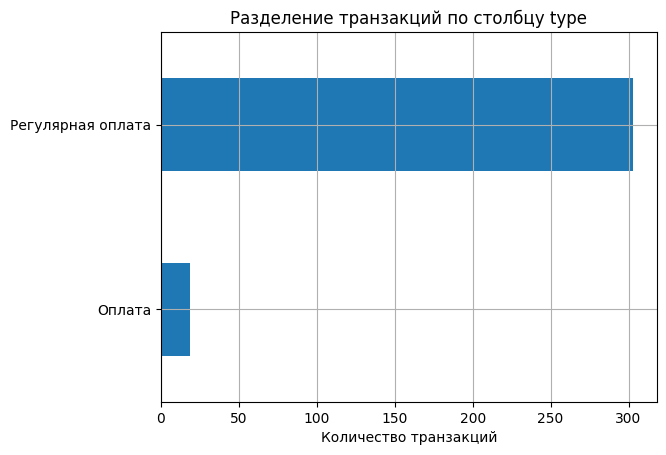

In [123]:
paym_type(declined, 'type')

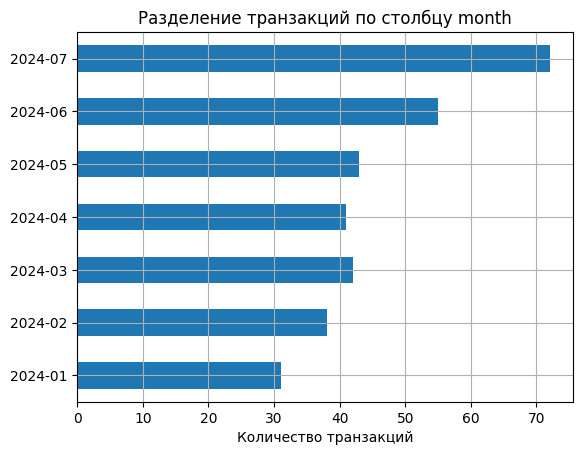

In [124]:
paym_type(declined, 'month')

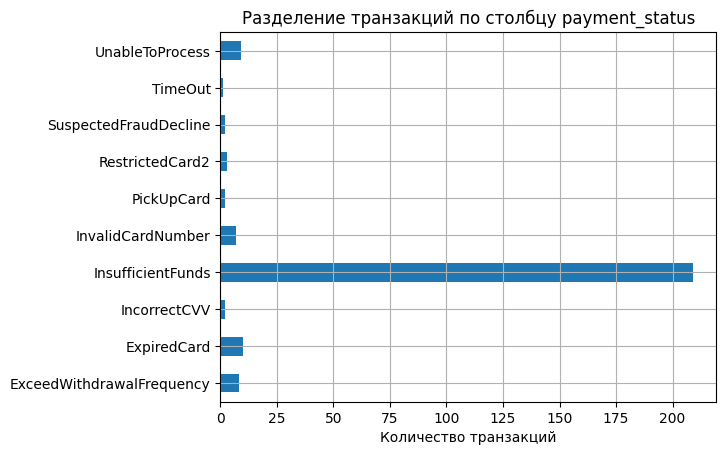

In [125]:
paym_type(declined, 'payment_status')

In [126]:
declined.value_counts('payment_status')

,count
payment_status,
InsufficientFunds,209
ExpiredCard,10
UnableToProcess,9
ExceedWithdrawalFrequency,8
InvalidCardNumber,7
RestrictedCard2,3
IncorrectCVV,2
PickUpCard,2
SuspectedFraudDecline,2


In [127]:
declined.query('payment_status == "SuspectedFraudDecline"')

,id,action_date,action_date2,month,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,status2,comission_%,city,payment_status
126,2108961119,2024-04-19 20:42:00,2024-04-19,2024-04,Тинькофф,prostieveschi.ru,999999999.0,humblehelptope****@gmail.com,Регулярная оплата,50000,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,SuspectedFraudDecline
192,2111760234,2024-05-03 18:29:00,2024-05-03,2024-05,Тинькофф,prostieveschi.ru,999999999.0,m_ostrovs****@inbox.ru,Регулярная оплата,500,RUB,0.5,-0.5,RUB,отклонена,3.2,NaN,SuspectedFraudDecline


In [128]:
#Сумма несвершившихся оплат
print(f"Сумма упущенных платежей: {declined['operation_sum'].sum()} руб.")

Сумма упущенных платежей: 201563 руб.


Отмененных платежей больше всего в июле, и чаще всего это регулярные платежи.

###Датафрейм completed

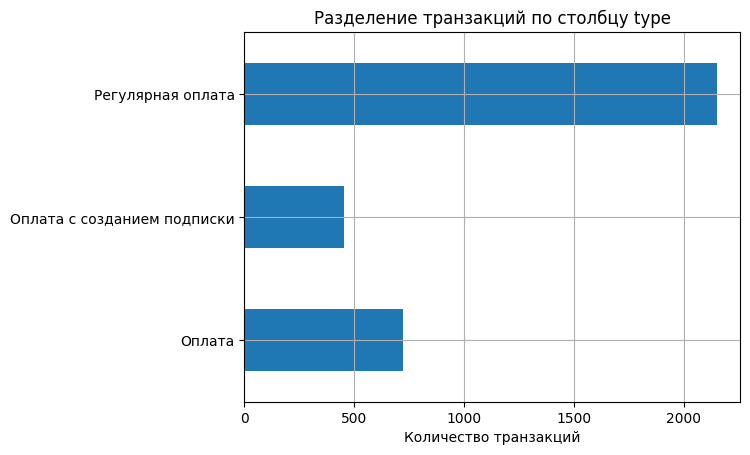

In [129]:
paym_type(completed, 'type')

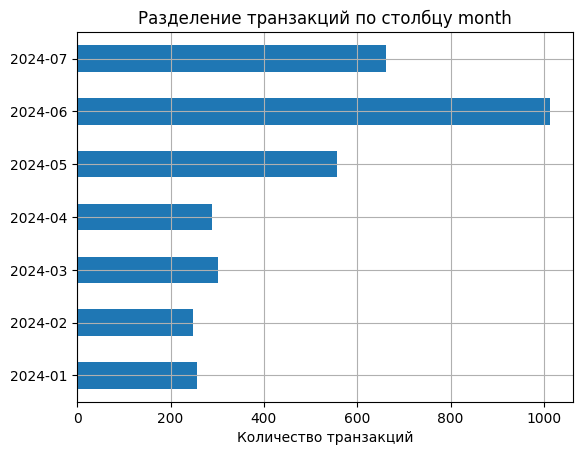

In [130]:
paym_type(completed, 'month')

In [131]:
completed['final_sum'].sum()

2458311.7

In [132]:
completed.groupby('month')['final_sum'].sum()

,final_sum
month,
2024-01,124392.63
2024-02,123089.33
2024-03,291027.79
2024-04,210658.83
2024-05,424136.68
2024-06,827029.69
2024-07,457976.75


In [133]:
#Топ 10 городов по проведенным оплатам
completed.value_counts('city').head(10)

,count
city,
Москва,230
Санкт-Петербург,173
Екатеринбург,14
Краснодар,11
Вена,8
Ростов-на-Дону,8
Франкфурт-на-Майне,7
Новосибирск,7
Нижний Новгород,7


In [134]:
#Среднее количество транзакций на город
completed.query('~city.isna()').value_counts('city').mean()

4.538461538461538

In [135]:
#Медианное количество транзакций на город
completed.query('~city.isna()').value_counts('city').median()

1.0

In [136]:
completed.query('~city.isna()')['city'].nunique()

156

Оценим клиентов по наличию order_id, возможно наличие order_id связано с оформлением заказа на продукцию компании, отсутствие - на пожертвование

In [137]:
completed.query('order_id !=999999999').value_counts('type')

,count
type,
Оплата,722
Оплата с созданием подписки,445


In [138]:
completed['purchase'] = completed['order_id'] < 999999999

In [139]:
completed.value_counts('purchase')

,count
purchase,
False,2159
True,1167


In [140]:
#Количество уникальных клиентов без номера заказа
completed.loc[completed['purchase'] ==False]['customer'].nunique()

710

In [141]:
#Количество уникальных клиентов с номером заказа
completed.loc[completed['purchase'] ==True]['customer'].nunique()

1065

In [142]:
#Всего уникальных клиентов
completed['customer'].nunique()

1476

In [143]:
def assign_category(purchases):
  unique_values = set(purchases)
  if unique_values == {True}:  # Только True
    return 1
  elif unique_values == {False}:  # Только False
    return 2
  else:  # Есть и True, и False
    return 3

In [144]:
categories = completed.groupby('customer')['purchase'].apply(assign_category).reset_index()
categories

,customer,purchase
0,****@bk.ru,1
1,****@de.ru,1
2,****@eml.cc,1
3,****@gksnab.ru,1
4,****@gmail.com,1
...,...,...
1471,zotova.liuda****@yandex.ru,1
1472,zvon****@gmail.com,1
1473,zxc****@yandex.ru,2
1474,zxc2081@yandex.ru,1


In [145]:
categories.groupby('purchase')['customer'].count()

,customer
purchase,
1,766
2,411
3,299


##RFM-анализ

In [146]:
#Определим дату для расчета давности покупки
limit_day = completed['action_date'].max() + timedelta(days=1)
limit_day

Timestamp('2024-08-01 21:34:00')

In [147]:
completed.head()

,id,action_date,action_date2,month,bank,site,order_id,customer,type,operation_sum,operation_currency,comission_sum,final_sum,final_currency,status2,comission_%,city,purchase
0,2080468405,2024-01-31 20:18:00,2024-01-31,2024-01,Тинькофф,prostieveschi.ru,999999999.0,12ost****@mail.ru,Регулярная оплата,1000,RUB,32.0,968.0,RUB,завершена,3.2,NaN,False
1,2080039460,2024-01-30 22:18:00,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,tigro****@gmail.com,Регулярная оплата,200,RUB,6.4,193.6,RUB,завершена,3.2,NaN,False
2,2079851261,2024-01-30 14:55:00,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,nat****@gmail.com,Регулярная оплата,300,RUB,9.6,290.4,RUB,завершена,3.2,NaN,False
3,2079846986,2024-01-30 14:45:00,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,natalk****@inbox.ru,Регулярная оплата,700,RUB,22.4,677.6,RUB,завершена,3.2,NaN,False
4,2079829457,2024-01-30 14:09:00,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,in****@yandex.ru,Регулярная оплата,500,RUB,16.0,484.0,RUB,завершена,3.2,NaN,False


In [148]:
#Сгруппируем данные по клиентам и рассчитаем давность покупки, количество заказов, частоту и доход с клиента.
df_customers = completed.groupby('customer', as_index=False).agg(
    recency=('action_date', lambda x: (limit_day - x.max()).days),
    first_purchase=('action_date', 'min'),  #Дата первой покупки
    last_purchase=('action_date', 'max'), #Дата последней покупки
    total_transactions=('id', 'count'),  # Количество транзакций клиента
    monetary=('final_sum', 'sum')  # Сумма покупок
).reset_index()

# Количество активных месяцев
df_customers['active_period_months'] = ((df_customers['last_purchase'].dt.normalize() - df_customers['first_purchase'].dt.normalize()).dt.days / 30).clip(lower=1)

# Частота переводов
df_customers['frequency'] = (df_customers['total_transactions'] / df_customers['active_period_months']).round(2)

df_customers.sample(5)

,index,customer,recency,first_purchase,last_purchase,total_transactions,monetary,active_period_months,frequency
145,145,Kiasportage@mail.ru,59,2024-06-03 14:04:00,2024-06-03 14:04:00,1,968.0,1.0,1.0
133,133,J.moscow****@gmail.com,10,2024-06-22 02:15:00,2024-07-22 02:16:00,2,192.2,1.0,2.0
1379,1379,valeriyavarvar****@gmail.com,5,2024-06-26 22:20:00,2024-07-26 22:20:00,2,968.0,1.0,2.0
205,205,Nastia****@mail.ru,26,2024-07-06 12:22:00,2024-07-06 12:22:00,1,968.0,1.0,1.0
856,856,kuryanova****@gmail.con,18,2024-06-14 10:22:00,2024-07-14 10:23:00,2,387.2,1.0,2.0


In [149]:
df_customers.query('customer == "morozov****@list.ru"')

,index,customer,recency,first_purchase,last_purchase,total_transactions,monetary,active_period_months,frequency
1025,1025,morozov****@list.ru,64,2024-03-20 14:08:00,2024-05-29 14:05:00,20,5808.0,2.333333,8.57


In [150]:
print(f'В датафрейме {df_customers.shape[0]} клиентов')

В датафрейме 1476 клиентов


<Figure size 1400x600 with 0 Axes>

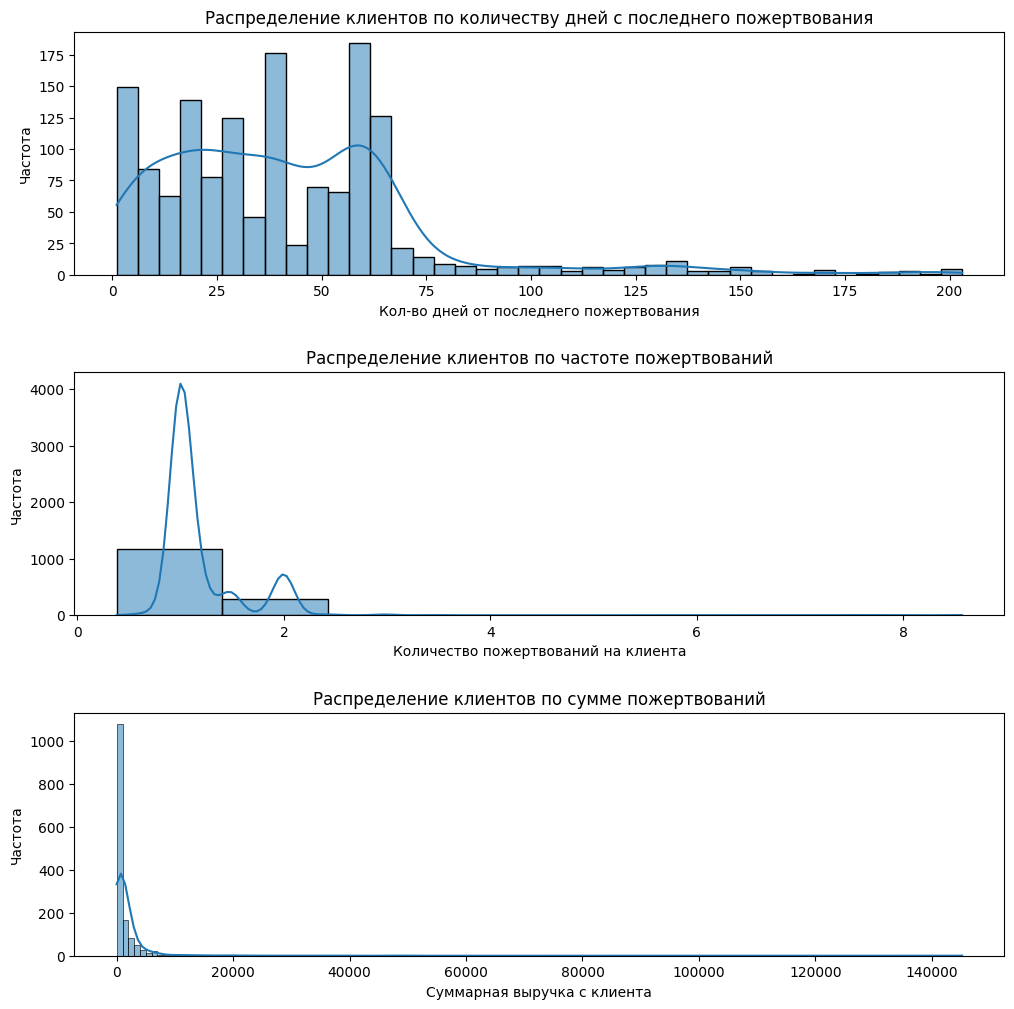

In [151]:
plt.figure(figsize=(14,6))

f, axes = plt.subplots(figsize=(12, 12), nrows=3)

sns.histplot(df_customers['recency'],
             kde=True, binwidth=5,
             ax=axes[0]).set(title= 'Распределение клиентов по количеству дней с последнего пожертвования',
                             xlabel='Кол-во дней от последнего пожертвования',
                             ylabel='Частота')

sns.histplot(df_customers['frequency'],
             kde=True, binwidth=1,
             ax=axes[1]).set(title= 'Распределение клиентов по частоте пожертвований',
                             xlabel='Количество пожертвований на клиента',
                             ylabel='Частота')

sns.histplot(df_customers['monetary'],
             kde=True, binwidth=1000,
             ax=axes[2]).set(title= 'Распределение клиентов по сумме пожертвований',
                             xlabel='Суммарная выручка с клиента',
                             ylabel='Частота')

plt.subplots_adjust(wspace=0, hspace=0.4)
plt.show()

count    1476.000000
mean        1.195549
std         0.444224
min         0.380000
25%         1.000000
50%         1.000000
75%         1.150000
max         8.570000
Name: frequency, dtype: float64


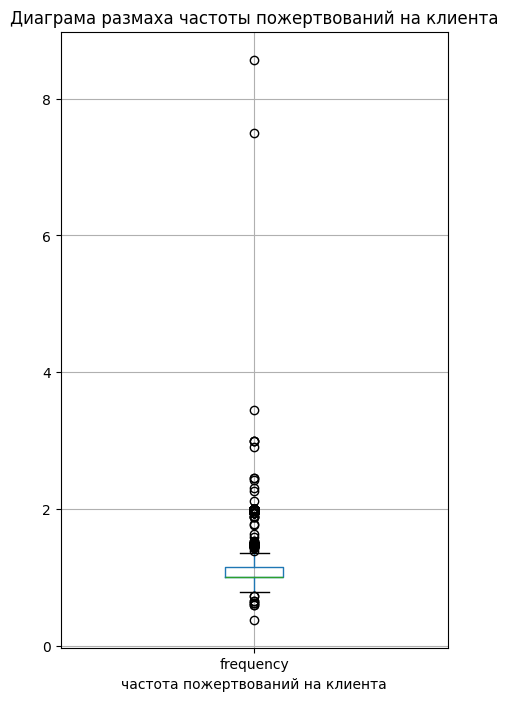

In [152]:
print(df_customers['frequency'].describe())

df_customers[['customer', 'frequency']].boxplot(figsize=(5,8))

plt.title('Диаграма размаха частоты пожертвований на клиента')
plt.xlabel('частота пожертвований на клиента')
plt.show()

count    1476.000000
mean        1.195549
std         0.444224
min         0.380000
25%         1.000000
50%         1.000000
75%         1.150000
max         8.570000
Name: frequency, dtype: float64


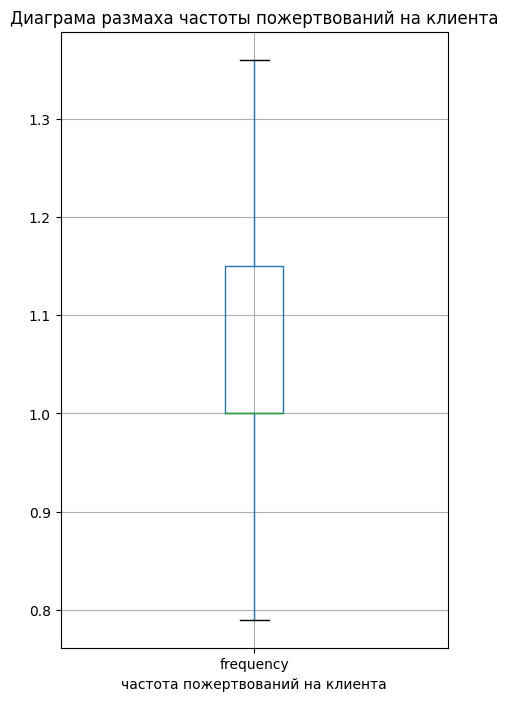

In [153]:
print(df_customers['frequency'].describe())

df_customers[['customer', 'frequency']].boxplot(figsize=(5,8), showfliers=False)

plt.title('Диаграма размаха частоты пожертвований на клиента')
plt.xlabel('частота пожертвований на клиента')
plt.show()

На диаграмме размаха видны выбросы, максимальное частота пожертвований - 8,6 в месяц, медианная частота - 1 заказов в месяц.

Построим точечный график частоты пожертвований по пользователям и посчитаем 95-й и 99-й перцентили частоты заказов на пользователя.

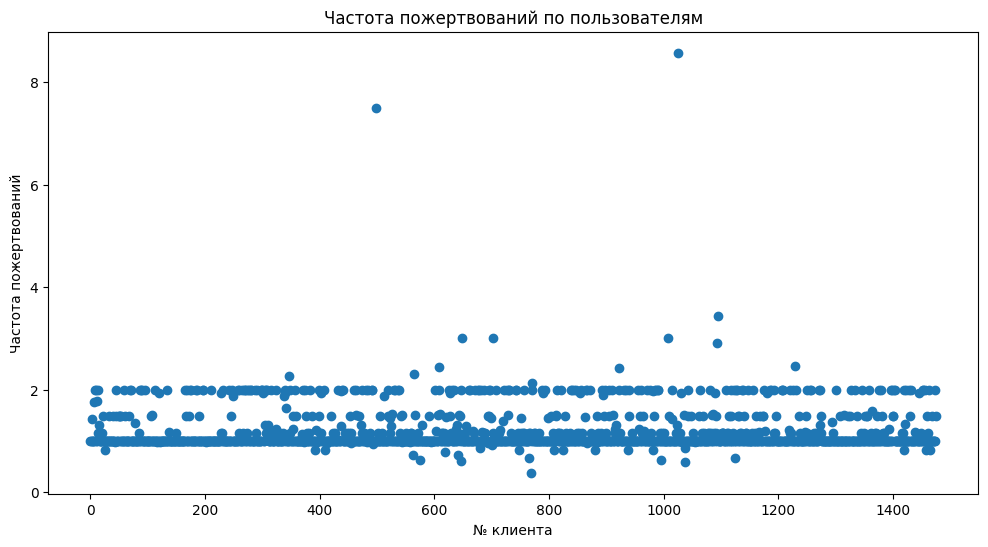

In [154]:
x_values = pd.Series(range(0, len(df_customers)))

plt.figure(figsize=(12,6))
plt.scatter(x_values, df_customers['frequency'])
plt.title('Частота пожертвований по пользователям')
plt.xlabel('№ клиента')
plt.ylabel('Частота пожертвований')
plt.show()

In [155]:
print('95й перцентиль:', round(np.percentile(df_customers['frequency'], 95), 0))
print('99й перцентиль:', round(np.percentile(df_customers['frequency'], 99),0))

95й перцентиль: 2.0
99й перцентиль: 2.0


В целом мы можем сказать, что совершение более 2 пожертвований в месяц не свойственно для наших клиентов. Клиентов, совершшающих более 2 пожертвований в месяц менее 1%.

Оценим данные по выручке с клиента.

count      1476.000000
mean       1665.522832
std        5376.766771
min           6.100000
25%         387.200000
50%         672.700000
75%        1379.400000
max      145200.000000
Name: monetary, dtype: float64


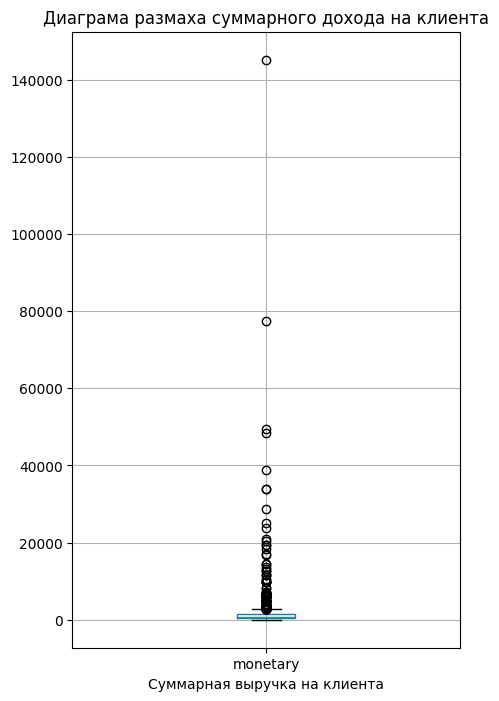

In [156]:
print(df_customers['monetary'].describe())

df_customers[['customer', 'monetary']].boxplot(figsize=(5,8))

plt.title('Диаграма размаха суммарного дохода на клиента')
plt.xlabel('Суммарная выручка на клиента')
plt.show()

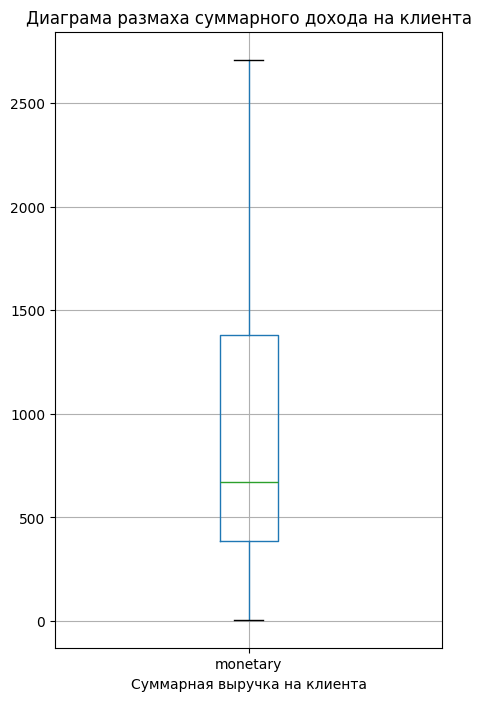

In [157]:
df_customers[['customer', 'monetary']].boxplot(figsize=(5,8), showfliers=False)

plt.title('Диаграма размаха суммарного дохода на клиента')
plt.xlabel('Суммарная выручка на клиента')
plt.show()

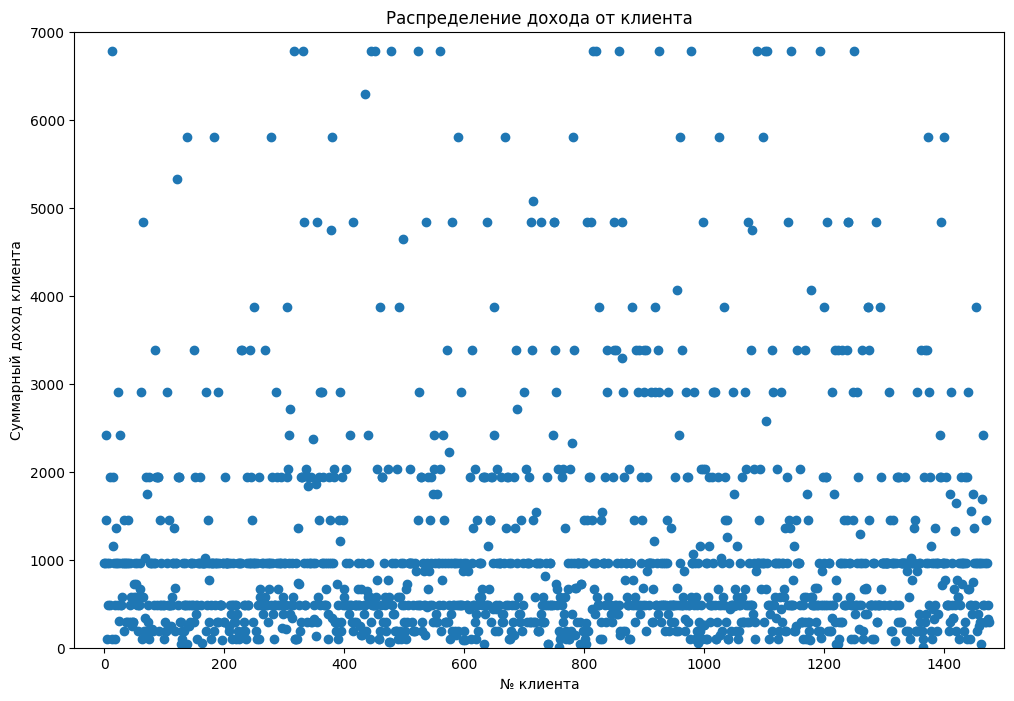

In [158]:
#Ограничим ось Y до суммы 7000 руб.на клиента
x_values = pd.Series(range(0, len(df_customers)))

plt.figure(figsize=(12,8))
plt.scatter(x_values, df_customers['monetary'])
plt.title('Распределение дохода от клиента')
plt.xlabel('№ клиента')
plt.ylabel('Суммарный доход клиента')
plt.axis([-50, 1500, 0, 7000])
plt.show()

In [159]:
print('95й перцентиль:', round(np.percentile(df_customers['monetary'], 95), 0))
print('99й перцентиль:', round(np.percentile(df_customers['monetary'], 99),0))

95й перцентиль: 4840.0
99й перцентиль: 17303.0


Медианное значение дохода с клиента - 672 руб., В 95% случаев клиенты переводили суммарно до 4 840 руб за 7 месяцев. В 99% случаев клиенты переводили суммарно до 17 303 руб за 7 месяцев. Но есть клиенты, переводившие суммарно и 140 000 руб. и 79 000.



Разделение клиентов на группы:

R - давность последнего перевода, 1 - недавно (0 - 31 день назад), 2 - средняя давность (32-91 день назад), 3 - давно (91-203 дня назад)

F - частота заказов в месяц, 1 - 1 заказ, 2 - 2 заказа, 3 - более 2х заказов

M - сумма пожертвований, 1 - 1-1000 руб., 2 - 1001-5000 руб., 3 - 5001-145200руб.

In [160]:
#Создадим маркировку для сегментов
r_labels = range(3, 0, -1); f_labels = range(1, 4); m_labels = range(1, 4)

#Разделим данные в столбце recency на 3 группы
r_groups = pd.cut(df_customers['recency'], bins=[0, 31, 91, 203], labels=r_labels)
#Разделим данные в столбце frequency на 4 группы
f_groups = pd.cut(df_customers['frequency'],  bins=[0, 1, 2, 9], labels=f_labels)
#Разделим данные в столбце monetary на 3 группы
m_groups = pd.cut(df_customers['monetary'], bins=[0, 1000, 5000, 145200], labels=m_labels)

In [161]:
#Применим разделение к датафрейму
df_customers = df_customers.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)

In [162]:
df_customers.sample(10)

,index,customer,recency,first_purchase,last_purchase,total_transactions,monetary,active_period_months,frequency,R,F,M
1359,1359,tutmo****@gmail.com,23,2024-07-09 17:14:00,2024-07-09 17:14:00,1,968.0,1.000000,1.00,3,1,1
1274,1274,simagavri****@gmail.com,6,2024-05-26 02:14:00,2024-07-26 02:14:00,3,1452.0,2.033333,1.48,3,2,2
1155,1155,osenz****@gmail.com,15,2024-01-17 21:13:00,2024-07-17 21:13:00,7,3388.0,6.066667,1.15,3,2,2
1058,1058,nastenka0810****@gmail.com,40,2024-06-22 21:31:00,2024-06-22 21:31:00,1,193.6,1.000000,1.00,2,1,1
46,46,Ajs****@mail.ru,34,2024-06-28 20:45:00,2024-06-28 20:45:00,1,242.0,1.000000,1.00,2,1,1
1050,1050,nadine****@mail.ru,5,2024-01-27 15:32:00,2024-07-27 15:33:00,6,1742.4,6.066667,0.99,3,1,2
1074,1074,natadem****@gmail.com,40,2024-06-22 10:17:00,2024-06-22 10:17:00,1,968.0,1.000000,1.00,2,1,1
704,704,hyakov@mail.ru,58,2024-06-04 10:01:00,2024-06-04 10:01:00,1,290.4,1.000000,1.00,2,1,1
552,552,dfuf****@mail.ru,40,2024-06-22 14:43:00,2024-06-22 14:43:00,1,290.4,1.000000,1.00,2,1,1
712,712,in****@yandex.ru,2,2024-01-30 14:09:00,2024-07-30 14:09:00,7,3388.0,6.066667,1.15,3,2,2


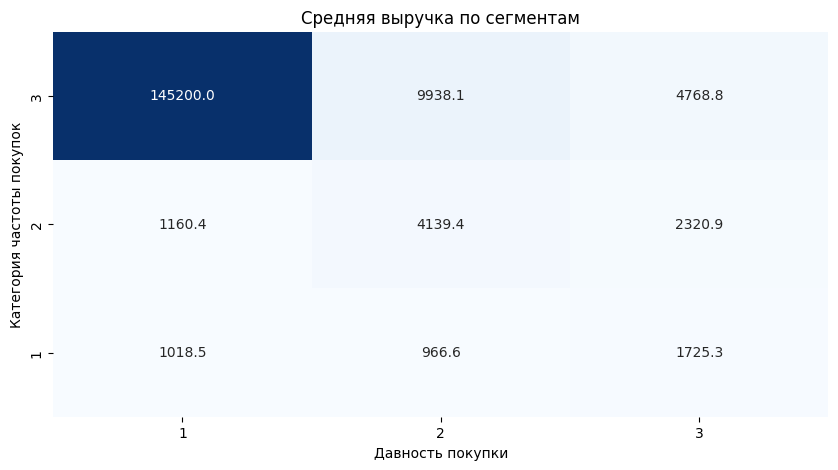

In [163]:
#Выведем тепловую карту по R (recency) и F (frequency) со средних покупок
rfm_table = df_customers.pivot_table(index='F',
                                    columns='R',
                                    values='monetary',
                                    aggfunc='mean',
                                    observed=False)

plt.figure(figsize=(10,5))
sns.heatmap(rfm_table, annot=True,fmt='.1f', cmap='Blues', cbar=False)


plt.title('Средняя выручка по сегментам')
plt.xlabel('Давность покупки')
plt.ylabel('Категория частоты покупок')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

Для наглядности поставим ограничение в столбце monetary в 20 000 руб.

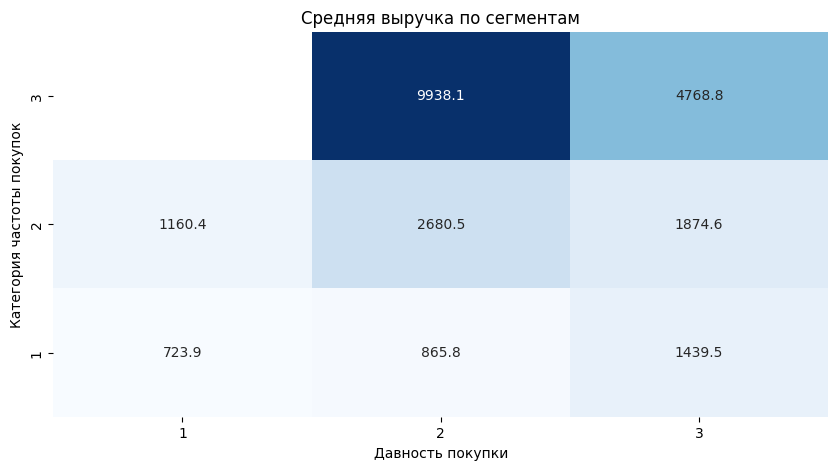

In [164]:
plt.figure(figsize=(10,5))
sns.heatmap(df_customers.loc[df_customers['monetary'] < 20000].pivot_table(index='F',
                                    columns='R',
                                    values='monetary',
                                    aggfunc='mean',
                                    observed=False), annot=True,fmt='.1f', cmap='Blues', cbar=False)


plt.title('Средняя выручка по сегментам')
plt.xlabel('Давность покупки')
plt.ylabel('Категория частоты покупок')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [165]:
#Распределим клиентов на группы с помощью регулярных выражений
segm_map={
    r'3[1-3]3' : 'VIP клиенты',
    r'3[1-3][1-2]' : 'лояльные',
    r'1[1-2][1-3]' : 'ушедшие',
    r'2[1-3][1-3]' : 'спящие',
    r'[1-2][2-3]3' : 'VIP (ушедшие)',

}

#Соединим в один столбец значения из столбцов R, F и M
df_customers['RFM'] = df_customers['R'].astype(str)+df_customers['F'].astype(str)+df_customers['M'].astype(str)

#Добавим столбец с названием сегмента на основании столбца RFM
df_customers['segment'] = df_customers['RFM'].replace(segm_map, regex=True)

Добавим столбец со средним чеком на клиента.

In [166]:
df_customers['avg_bill'] = df_customers['monetary'] / df_customers['total_transactions']
df_customers.sample(5)

,index,customer,recency,first_purchase,last_purchase,total_transactions,monetary,active_period_months,frequency,R,F,M,RFM,segment,avg_bill
1107,1107,nj.kaz****@yandex.ru,66,2024-05-27 16:19:00,2024-05-27 16:19:00,1,96.1,1.000000,1.00,2,1,1,211,спящие,96.1
1013,1013,mjacov****@gmail.com,63,2024-05-30 19:56:00,2024-05-30 19:56:00,1,1936.0,1.000000,1.00,2,1,2,212,спящие,1936.0
1304,1304,sou****@bk.ru,41,2024-06-20 21:35:00,2024-06-20 21:35:00,1,968.0,1.000000,1.00,2,1,1,211,спящие,968.0
1306,1306,spacumo****@gmail.com,66,2024-05-27 14:50:00,2024-05-27 14:50:00,1,968.0,1.000000,1.00,2,1,1,211,спящие,968.0
957,957,maria.tre****@gmail.com,92,2024-01-01 11:32:00,2024-05-01 11:32:00,5,2420.0,4.033333,1.24,1,2,2,122,ушедшие,484.0


In [167]:
#Добавим информацию по сегментам для визуализации в Tableau
completed = completed.merge(df_customers[['customer', 'RFM', 'segment','R', 'F', 'M']], how='left', on='customer')
completed.sample(5)

,id,action_date,action_date2,month,bank,site,order_id,customer,type,operation_sum,...,final_currency,status2,comission_%,city,purchase,RFM,segment,R,F,M
1971,2120638749,2024-06-22 13:14:00,2024-06-22,2024-06,Тинькофф,prostieveschi.ru,22313.0,Yuliya-kruzha****@yandex.ru,Оплата,500,...,RUB,завершена,3.2,Геленджик,True,211,спящие,2,1,1
641,2100269649,2024-03-16 22:37:00,2024-03-16,2024-03,Тинькофф,prostieveschi.ru,999999999.0,cooloorta.****@gmail.com,Регулярная оплата,500,...,RUB,завершена,3.2,NaN,False,111,ушедшие,1,1,1
860,2109682230,2024-04-23 12:02:00,2024-04-23,2024-04,Тинькофф,prostieveschi.ru,999999999.0,irin****@yandex.ru,Регулярная оплата,100,...,RUB,завершена,3.2,NaN,False,222,спящие,2,2,2
2762,2126497339,2024-07-27 19:15:00,2024-07-27,2024-07,Тинькофф,prostieveschi.ru,23501.0,maryanaz****@gmail.com,Оплата,300,...,RUB,завершена,3.2,Новоуральск,True,321,лояльные,3,2,1
1808,2121368596,2024-06-26 20:38:00,2024-06-26,2024-06,Тинькофф,prostieveschi.ru,22534.0,Irk****@mail.ru,Оплата,1000,...,RUB,завершена,3.2,Санкт-Петербург,True,211,спящие,2,1,1


Сгруппируем данные по выделенным сегментам и рассчитаем:
- среднее количество дней с последней покупки
- среднее количество покупок
- среднюю выручку
- количество клиентов в сегменте
- размер среднего чека

In [168]:
rfm_customers = df_customers.groupby('segment', as_index=False).agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count', 'sum'],
    'avg_bill': 'mean'
}).round(1)

rfm_customers.columns = rfm_customers.columns.droplevel()
rfm_customers.columns = [
    'segment', 'avg_days_after_buy', 'avg_freq_purchases', 'avg_revenue', 'customer_qnt', 'total_revenue', 'avg_bill'
]
rfm_customers

,segment,avg_days_after_buy,avg_freq_purchases,avg_revenue,customer_qnt,total_revenue,avg_bill
0,VIP (ушедшие),135.0,3.0,145200.0,1,145200.0,48400.0
1,VIP клиенты,15.1,1.2,11825.9,54,638600.5,2898.8
2,лояльные,16.4,1.4,1249.3,584,729562.2,470.7
3,спящие,53.3,1.0,1138.3,748,851462.5,963.4
4,ушедшие,135.0,1.1,1050.4,89,93486.4,867.3


In [169]:
#Сгруппируем данные по месяцу и сегменту и расчитаем средний чек и сумму продаж
df_segm_month = completed.groupby(['month','segment'],
                                  as_index=False).agg({'final_sum': ['mean', 'sum']})

df_segm_month.columns = df_segm_month.columns.droplevel()
df_segm_month.columns = ('month', 'segment', 'avg_bill', 'revenue')
df_segm_month[['avg_bill', 'revenue']] = df_segm_month[['avg_bill', 'revenue']].round(0).astype('int')
df_segm_month.head(10)

,month,segment,avg_bill,revenue
0,2024-01,VIP клиенты,1274,57329
1,2024-01,лояльные,287,48294
2,2024-01,спящие,566,7353
3,2024-01,ушедшие,381,11418
4,2024-02,VIP клиенты,1271,59749
5,2024-02,лояльные,286,48535
6,2024-02,спящие,558,7256
7,2024-02,ушедшие,419,7549
8,2024-03,VIP (ушедшие),48400,145200
9,2024-03,VIP клиенты,1223,59933


In [170]:
cat_colors = {'VIP клиенты' : '#6d1b65',
              'VIP (ушедшие)': '#b59aa9',
              'лояльные' : '#098a9a',
              'перспективные': '#7ebdaf',
              'ушедшие': '#d8343e',
              'спящие': '#b5b5b5'
              }

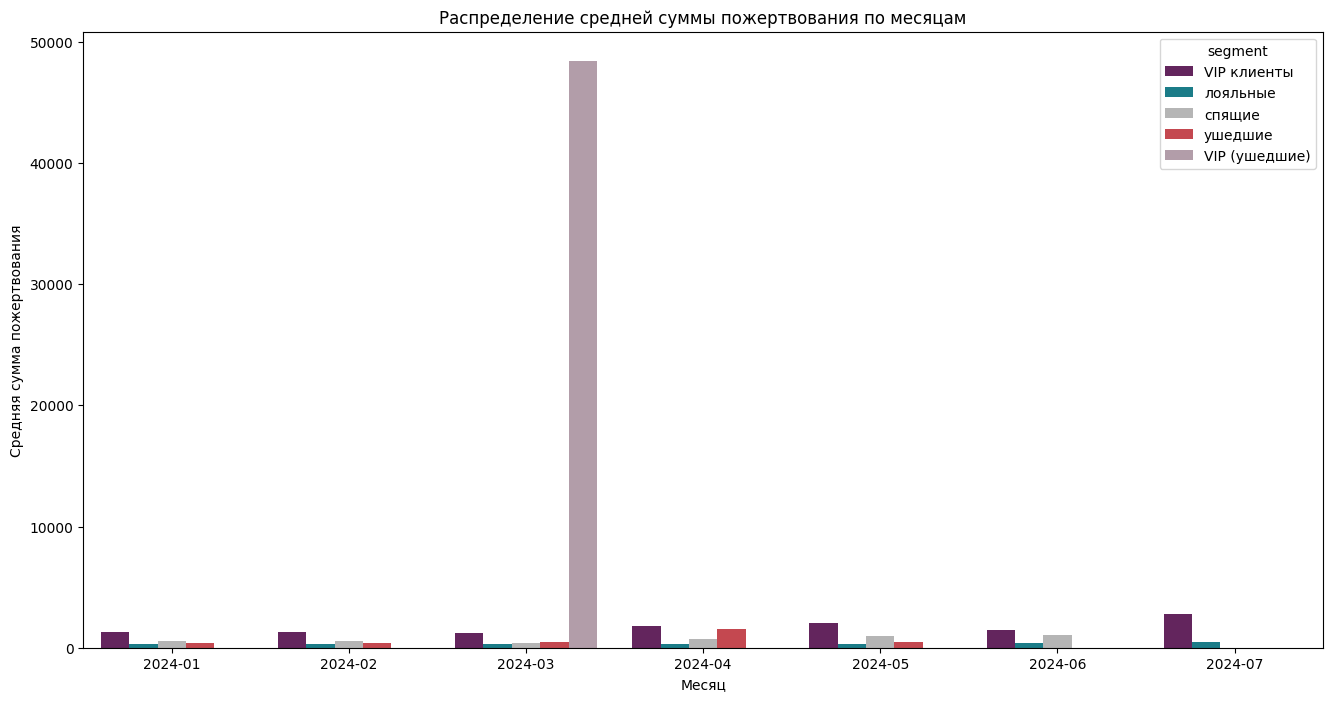

In [171]:
plt.figure(figsize=(16,8))
sns.barplot(data=df_segm_month,
             x='month',
                   y='avg_bill',
                   hue='segment',
                  palette= cat_colors
                  )


plt.title('Распределение средней суммы пожертвования по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средняя сумма пожертвования')

plt.show()

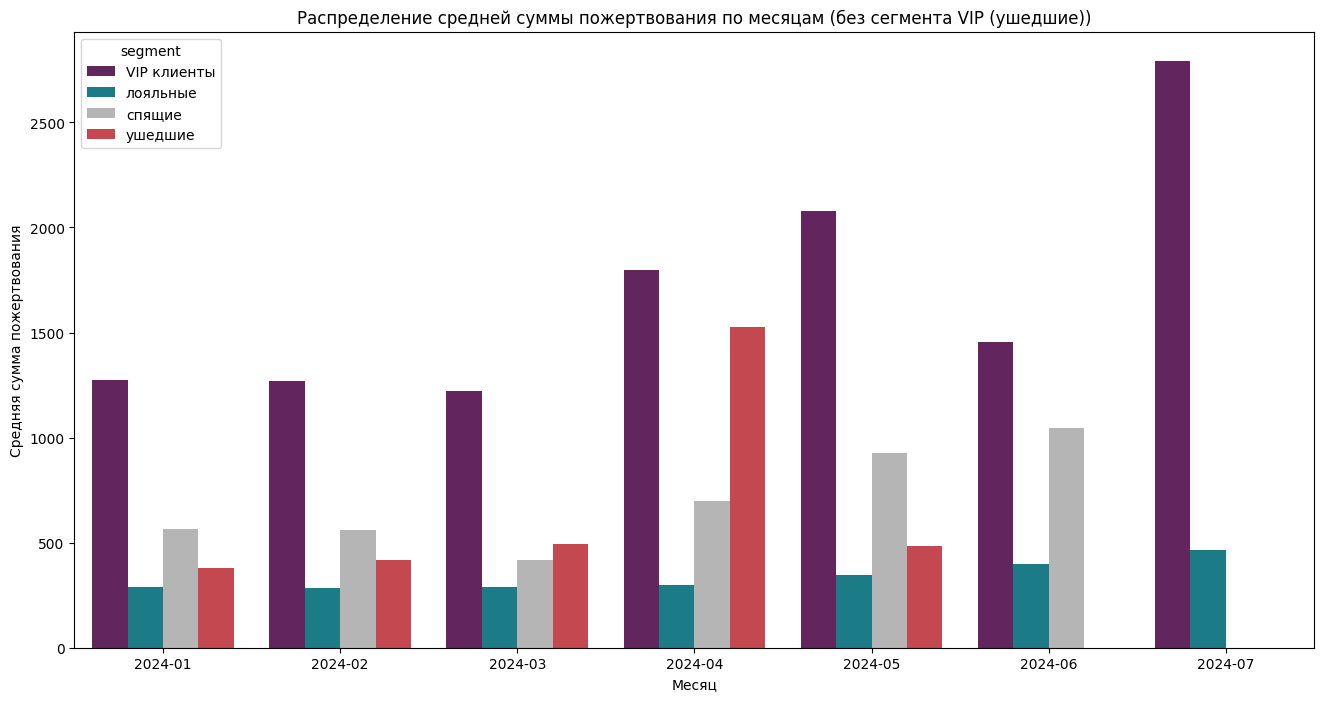

In [172]:
#Исключим сегмент VIP (ушедшие)
plt.figure(figsize=(16,8))
sns.barplot(data=df_segm_month.loc[df_segm_month['segment'] !="VIP (ушедшие)"],
             x='month',
                   y='avg_bill',
                   hue='segment',
                  palette=cat_colors
                  )

plt.title('Распределение средней суммы пожертвования по месяцам (без сегмента VIP (ушедшие))')
plt.xlabel('Месяц')
plt.ylabel('Средняя сумма пожертвования')
plt.show()

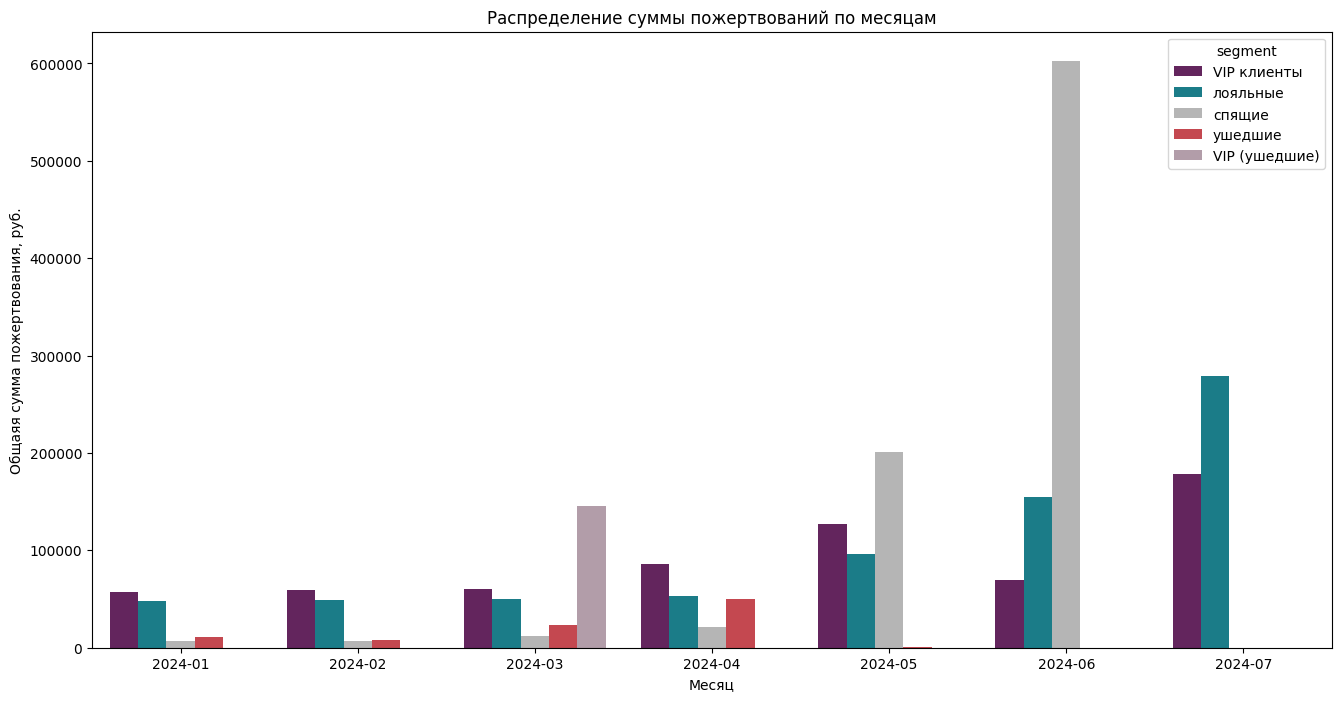

In [173]:
plt.figure(figsize=(16,8))
sns.barplot(data=df_segm_month,
             x='month',
                   y='revenue',
                   hue='segment',
                  palette=cat_colors
                  )
plt.title('Распределение суммы пожертвований по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Общаяя сумма пожертвования, руб.')

plt.show()

У нас получилось 5 сегментов клиентов
1.	**лояльные** - это клиенты, делавшие пожертвования недавно, до 31 день назад, 1-2 перевода в месяц, суммарных переводов до 5000 руб. У этого сегмента в среднем со дня перечисления прошло около 16 дней, средняя частота перечислений месяц 1.4, количество клиентов в этом сегменте 584. Средний чек 470 руб, общая сумма 729 562 р.
2.	**VIP клиенты** - это клиенты, делавшие пожертвования недавно, до 31 день назад, 1-2 перевода в месяц, суммарных переводов от 5000 руб. до 145 200 руб. У этого сегмента в среднем со дня перечисления прошло около 15 дней, средняя частота перечислений месяц 1.2, количество клиентов в этом сегменте 54. Средний чек почти 2900 руб., общая сумма 638 600 р.
3.	**спящие** - это клиенты, делавшие пожертвования относительно давно, 32-91 день назад, 1-2 перевода в месяц, суммарных переводов до 5000 руб. У этого сегмента в среднем со дня перечисления прошло около 53 дней, средняя частота перечислений в месяц 1, количество клиентов в этом сегменте 748. Средний чек 963 руб, общая сумма 851 462 р.
4.	**ушедшие** - это клиенты, делавшие пожертвования давно, более 91 дней назад, суммарных переводов до 5000 руб. У этого сегмента в среднем со дня перечисления прошло около 135 дней, средняя частота перечислений в месяц 1, количество клиентов в этом сегменте 89. Средний чек 867 руб, общая сумма 93 486 р.
5.	**VIP (ушедшие)** - это клиенты, делавшие пожертвования давно, более 91 дней назад, суммарных переводов более 5000 руб. У этого сегмента в среднем со дня перечисления прошло около 135 дней, средняя частота перечислений в месяц 3, количество клиентов в этом сегменте 1. Средний чек 48 400 руб, общая сумма 145 200р.

Можно отметить, что в июне был всплеск по суммарным пожертвованиям, но это были клиенты из сегменты спящие, и поэтому в июле этих платежей мы уже не наблюдаем.

Также можно отметить что к июлю вырос средний чек у сегмента VIP и до июня рос средний чек у сегмента спящие. Средний чек лояльных клиентов почти не вырос. Здесь можно рекомендовать мотивировать клиентов из сегмента лояльные покупать продукцию фонда, для получения дополнительного финансирования из этого сегмента.
Также важная задача переводить спящих клиентов в лояльных


##Когортный анализ

In [174]:
#Подготовим датафрейм с информацией о первых переводах клиентов
profiles = completed[['action_date', 'customer']].copy()

In [175]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3326 entries, 0 to 3325
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   action_date  3326 non-null   datetime64[ns]
 1   customer     3326 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 52.1+ KB


In [176]:
profiles = (
    completed.sort_values(by=['customer', 'action_date'])
    .groupby('customer')
    .agg({
        'action_date' : 'first',
    }).rename(columns={'action_date': 'first_ts'}).reset_index()
)

In [177]:
 profiles['month_dt'] = profiles['first_ts'].values.astype('datetime64[M]')
 profiles.head()

,customer,first_ts,month_dt
0,****@bk.ru,2024-06-13 18:33:00,2024-06-01
1,****@de.ru,2024-07-04 16:36:00,2024-07-01
2,****@eml.cc,2024-06-17 14:33:00,2024-06-01
3,****@gksnab.ru,2024-05-07 22:50:00,2024-05-01
4,****@gmail.com,2024-06-15 01:47:00,2024-06-01


In [178]:
#Добавим информацию для визуализации в Tableau

completed = completed.merge(profiles[['customer', 'first_ts']], how='left', on='customer')
completed.head()

,id,action_date,action_date2,month,bank,site,order_id,customer,type,operation_sum,...,status2,comission_%,city,purchase,RFM,segment,R,F,M,first_ts
0,2080468405,2024-01-31 20:18:00,2024-01-31,2024-01,Тинькофф,prostieveschi.ru,999999999.0,12ost****@mail.ru,Регулярная оплата,1000,...,завершена,3.2,NaN,False,323,VIP клиенты,3,2,3,2024-01-31 20:18:00
1,2080039460,2024-01-30 22:18:00,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,tigro****@gmail.com,Регулярная оплата,200,...,завершена,3.2,NaN,False,322,лояльные,3,2,2,2024-01-30 22:18:00
2,2079851261,2024-01-30 14:55:00,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,nat****@gmail.com,Регулярная оплата,300,...,завершена,3.2,NaN,False,322,лояльные,3,2,2,2024-01-30 14:55:00
3,2079846986,2024-01-30 14:45:00,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,natalk****@inbox.ru,Регулярная оплата,700,...,завершена,3.2,NaN,False,322,лояльные,3,2,2,2024-01-30 14:45:00
4,2079829457,2024-01-30 14:09:00,2024-01-30,2024-01,Тинькофф,prostieveschi.ru,999999999.0,in****@yandex.ru,Регулярная оплата,500,...,завершена,3.2,NaN,False,322,лояльные,3,2,2,2024-01-30 14:09:00


In [179]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1476 entries, 0 to 1475
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   customer  1476 non-null   object        
 1   first_ts  1476 non-null   datetime64[ns]
 2   month_dt  1476 non-null   datetime64[s] 
dtypes: datetime64[ns](1), datetime64[s](1), object(1)
memory usage: 34.7+ KB


###Функция для расчета Retention Rate

In [180]:
def get_retention(
    profiles, sessions, observation_date, horizon_months, ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - pd.DateOffset(months=horizon_months - 1
        )
    result_raw = profiles.query('month_dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['customer', 'action_date']], on='customer', how='left'
    )
    result_raw['lifetime'] = (
        (result_raw['action_date'].dt.to_period('M')) - (result_raw['first_ts'].dt.to_period('M'))
        ).apply(lambda x: x.n)

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['month_dt'], columns='lifetime', values='customer', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('month_dt')
        .agg({'customer': 'nunique'})
        .rename(columns={'customer': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='month_dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_months))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped

In [181]:
observation_date = profiles['month_dt'].max()
horizon_months = profiles['month_dt'].nunique()

retention_raw, retention = get_retention(profiles, completed,observation_date, horizon_months, ignore_horizon=True)
retention

,cohort_size,0,1,2,3,4,5,6
month_dt,,,,,,,,
2024-01-01,251,1.0,0.916335,0.892430,0.840637,0.844622,0.657371,0.828685
2024-02-01,12,1.0,0.583333,0.750000,0.666667,0.500000,0.583333,0.000000
2024-03-01,52,1.0,0.230769,0.288462,0.173077,0.211538,0.000000,0.000000
2024-04-01,42,1.0,0.309524,0.285714,0.238095,0.000000,0.000000,0.000000
2024-05-01,275,1.0,0.334545,0.356364,0.000000,0.000000,0.000000,0.000000
2024-06-01,698,1.0,0.226361,0.000000,0.000000,0.000000,0.000000,0.000000
2024-07-01,146,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


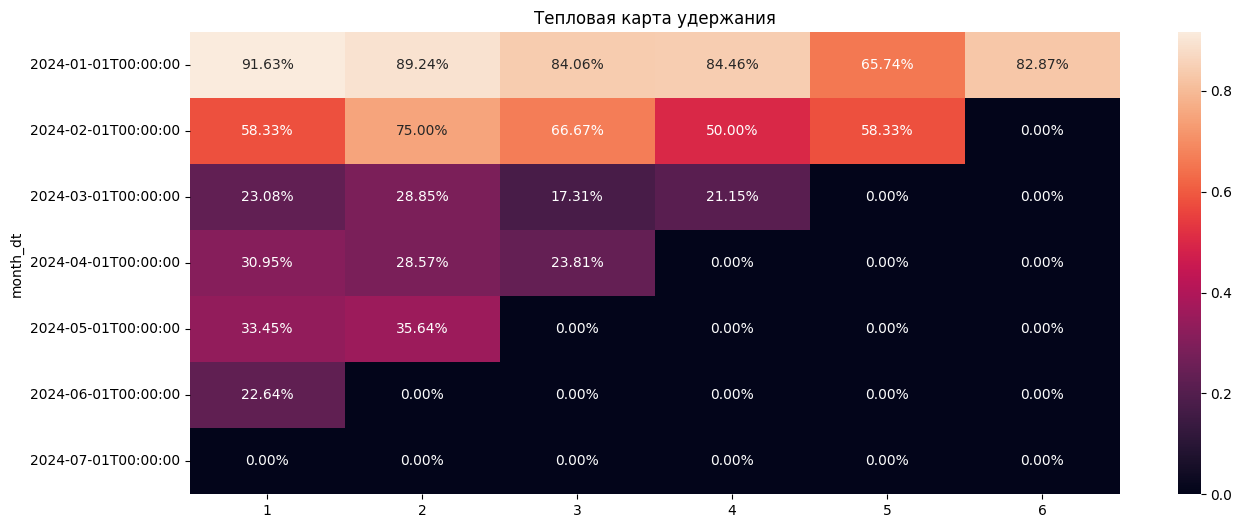

In [182]:
plt.figure(figsize = (15, 6))
sns.heatmap(retention.drop(columns = ['cohort_size', 0]), # удаляем размеры когорт
            annot = True,
            fmt = '.2%'
           )
plt.title('Тепловая карта удержания')
plt.show()

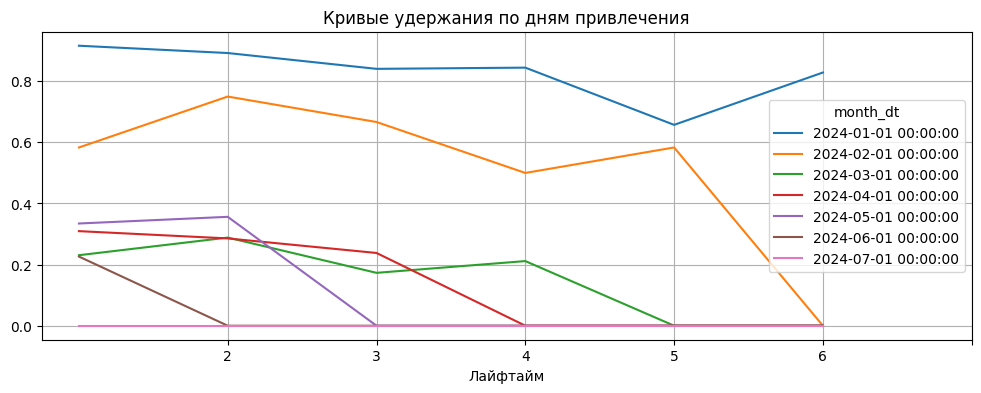

In [183]:
report = retention.drop(columns = ['cohort_size', 0])

report.T.plot(
    grid=True,
    xticks=list(report.columns.values),
    figsize=(12, 4),
)
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания по дням привлечения')
plt.show()

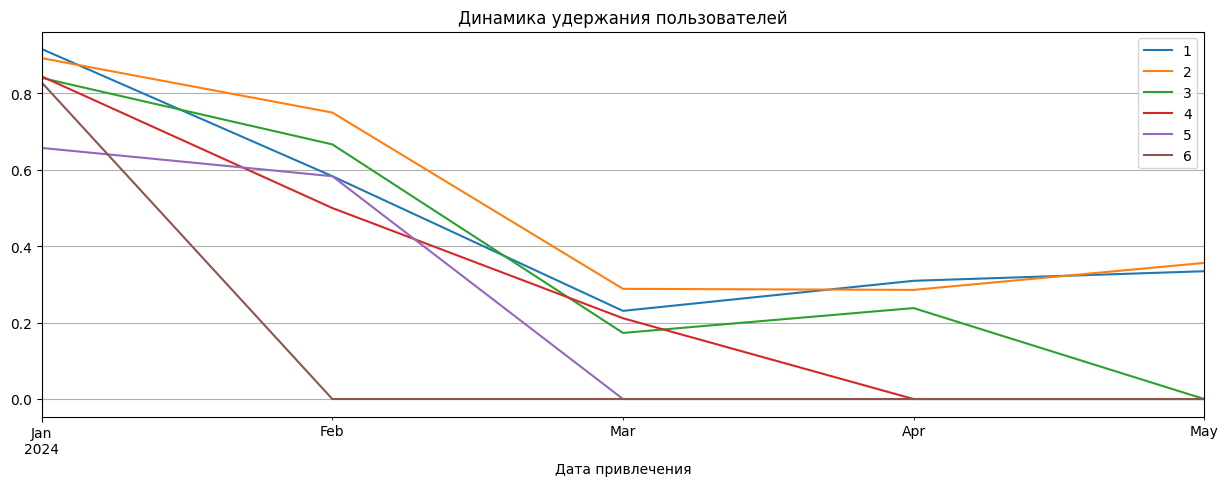

In [184]:
#Ограничим данный маем
report.query('month_dt < "2024-06-01"').plot(grid=True, figsize=(15, 5))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей')
plt.show()

**Самые многочисленные когорты – когорты января, мая и июня.**

**Январская когорта** показывает наивысший уровень удержания клиентов, вероятнее всего это постоянные клиенты, отчислявшие деньги и ранее.  Начиная с марта коэффициент удержания сильно падает. **С февраля по апрель** наименьший размер когорт.

**В мае и июне** пришло много новых клиентов и у них достаточно высокая средняя сумма месячных пожертвований на старте в сравнении с январем и февралем.

###Функция LTV

In [185]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_months,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - pd.DateOffset(months=horizon_months - 1
        )

    result_raw = profiles.query('month_dt <= @last_suitable_acquisition_date')

    # Добваляем данные о покупках в профили

    result_raw = result_raw.merge(
        # добавляем в профили время совершения покупок и выручку
        purchases[['customer', 'action_date', 'final_sum']],
        on='customer',
        how='left',
    )

    #Рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        (result_raw['action_date'].dt.to_period('M')) - (result_raw['first_ts'].dt.to_period('M'))
        ).apply(lambda x: x.n)

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_months):

        # Строим таблицу выручки
        # строим «треугольную» таблицу
        result = df.pivot_table(
            index=dims,
            columns='lifetime',
            values='final_sum',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )

        # Рассчитаем сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)

        # Вычислим размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'customer': 'nunique'})
            .rename(columns={'customer': 'cohort_size'})
        )

        # Объединим размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Посчитаем LTV
        # делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_months))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу LTV
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_months)

    # для таблицы динамики LTV убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
    # получаем таблицу динамики LTV
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['month_dt'], horizon_months
    )

    # возвращаем обе таблицы LTV и сырые данные
    return result_raw, result_grouped, result_in_time

In [186]:
horizon_months = 7
ltv_raw, ltv, ltv_history = get_ltv(
    profiles, completed, observation_date, horizon_months, ignore_horizon=True
)

ltv_history

,cohort_size,0,1,2,3,4,5,6
month_dt,,,,,,,,
2024-01-01,251,495.588167,963.811394,1408.160518,1869.092908,2370.155179,2773.729960,3267.365697
2024-02-01,12,463.775000,758.150000,1100.925000,1435.691667,1730.125000,2032.566667,2032.566667
2024-03-01,52,3383.916538,3680.831923,4427.190385,4535.357692,4818.298077,4818.298077,4818.298077
2024-04-01,42,1795.521429,2864.914286,3002.032381,3570.084762,3570.084762,3570.084762,3570.084762
2024-05-01,275,765.918945,942.553709,1131.174073,1131.174073,1131.174073,1131.174073,1131.174073
2024-06-01,698,948.769341,1053.840344,1053.840344,1053.840344,1053.840344,1053.840344,1053.840344
2024-07-01,146,1141.531644,1141.531644,1141.531644,1141.531644,1141.531644,1141.531644,1141.531644


In [187]:
ltv

,cohort_size,0,1,2,3,4,5,6
cohort,,,,,,,,
All users,1476,962.64622,1168.150793,1311.839905,1412.919939,1510.489539,1581.578001,1665.522832


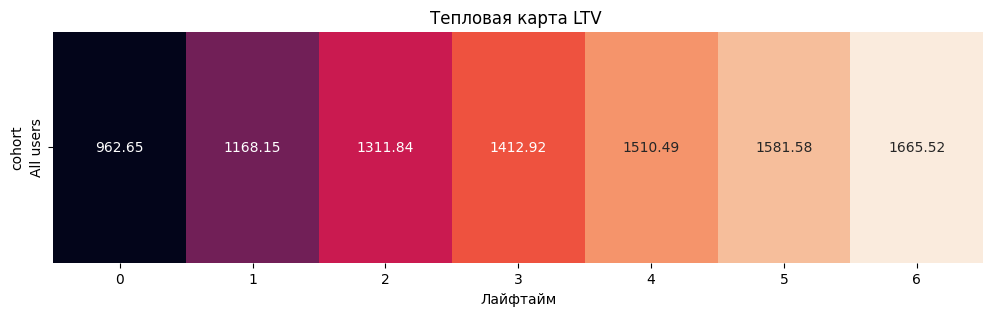

In [188]:
plt.figure(figsize=(12, 3))
sns.heatmap(ltv.drop(columns=['cohort_size']), annot=True, fmt='.2f', cbar=False)
plt.title('Тепловая карта LTV ')
plt.xlabel('Лайфтайм')
plt.show()

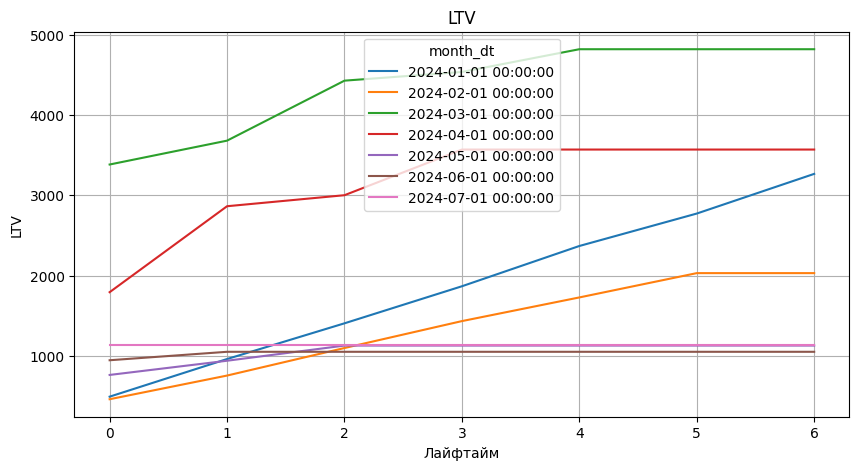

In [189]:
# строим кривые LTV

report = ltv_history.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5))
plt.title('LTV')
plt.ylabel('LTV')
plt.xlabel('Лайфтайм')
plt.show()

За счет своей многочисленности **июньская когорта принесла наивысшую выручку в первый месяц** и за два месяца она дает суммарную выручку на уровне 6 месяцев 1й когорты.

**Мартовская когорта** при своей малочисленности дает высокий LTV, это связано с большим платежом от клиента humblehelptope****@gmail.com на сумму 145 200 руб.

**Майская когорта** вторая по численности и по прибыльности на старте.

##Маркетинговый анализ

In [190]:
#Рассчитаем среднее количество уникальных жертвователей в день (DAU) за весь период
dau_total = completed.groupby('action_date2').agg({'customer': 'nunique'}).mean().astype('int')

dau_total

,0
customer,15


In [191]:
def dynamics_plt(df, col, type):
  df.groupby(col).agg({'customer': 'nunique'}).plot(grid=True, figsize=(15, 5))

  if type == 'day':
    period = 'день'
  elif type == 'month':
    period = 'месяц'
  elif type == 'year':
    period = 'год'

  else:
    period = type

  plt.title(f'Динамика уникальных жертвователей в {period}')
  plt.ylabel('Количество уникальных пользователей')
  plt.xlabel(f'{period}')
  plt.show()

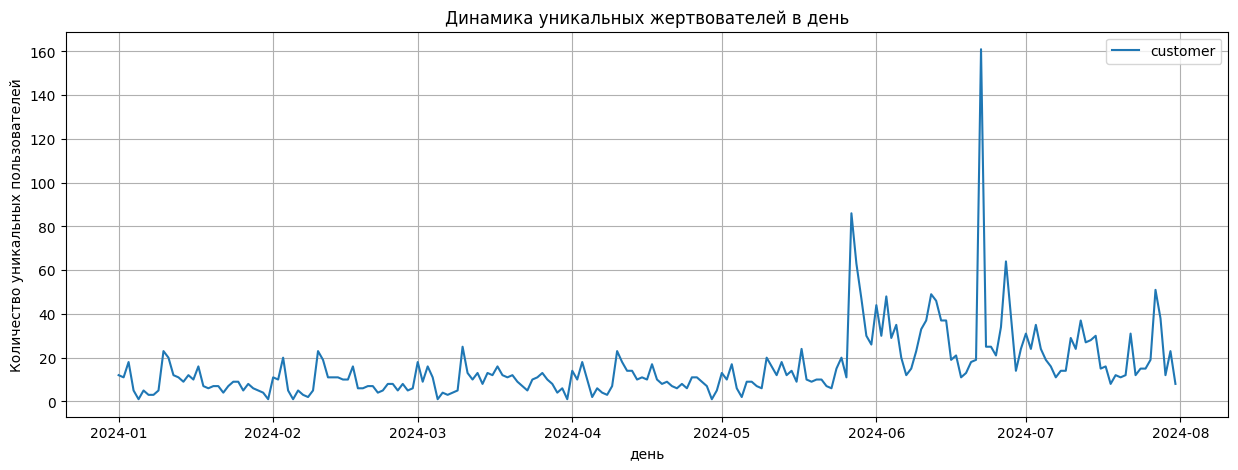

In [192]:
dynamics_plt(completed, 'action_date2', 'day')

In [193]:
#Рассчитаем количество уникальных жертвователей в месяц (MAU)
mau_total = completed.groupby('month').agg({'customer': 'nunique'}).mean().astype('int')

mau_total

,0
customer,456


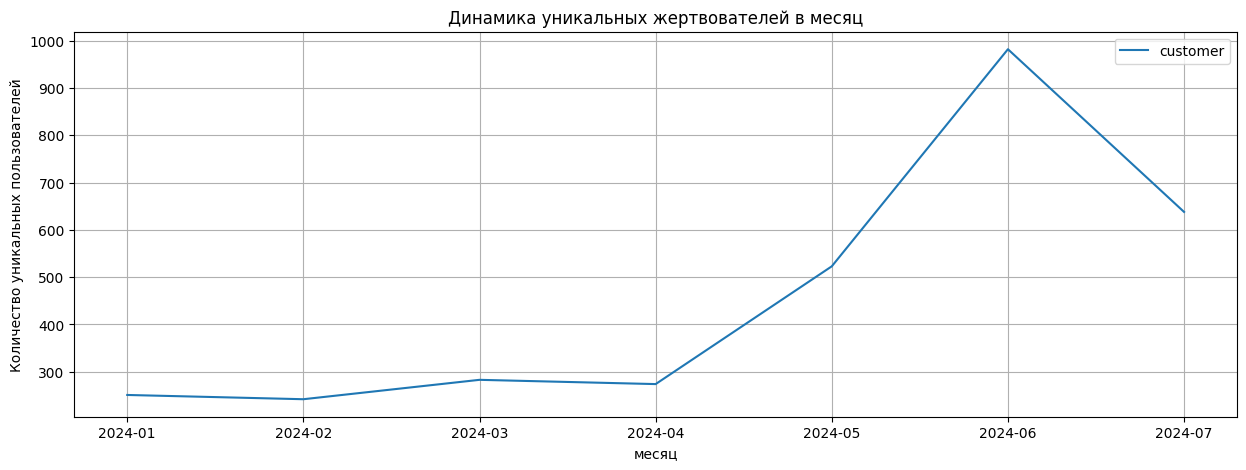

In [194]:
dynamics_plt(completed, 'month', 'month')

In [195]:
completed['action_year'] = completed['action_date'].dt.year
completed['action_week'] = completed['action_date'].dt.isocalendar().week

completed.sample(5)

,id,action_date,action_date2,month,bank,site,order_id,customer,type,operation_sum,...,city,purchase,RFM,segment,R,F,M,first_ts,action_year,action_week
2127,2119844630,2024-06-17 15:38:00,2024-06-17,2024-06,Тинькофф,prostieveschi.ru,22098.0,Elena.boly****@geropharm.com,Оплата,500,...,Москва,True,211,спящие,2,1,1,2024-06-17 15:38:00,2024,25
3300,2122244377,2024-07-01 20:22:00,2024-07-01,2024-07,Тинькофф,prostieveschi.ru,999999999.0,Gubi****@yandex.ru,Регулярная оплата,2000,...,NaN,False,313,VIP клиенты,3,1,3,2024-03-30 16:02:00,2024,27
2352,2118817291,2024-06-11 12:49:00,2024-06-11,2024-06,Тинькофф,prostieveschi.ru,21783.0,amb****@yandex.ru,Оплата с созданием подписки,1000,...,Москва,True,322,лояльные,3,2,2,2024-06-11 12:49:00,2024,24
1832,2121170446,2024-06-25 18:18:00,2024-06-25,2024-06,Тинькофф,prostieveschi.ru,22501.0,Aste****@inbox.ru,Оплата с созданием подписки,100,...,Москва,True,321,лояльные,3,2,1,2024-06-25 18:18:00,2024,26
2239,2119246801,2024-06-13 23:34:00,2024-06-13,2024-06,Тинькофф,prostieveschi.ru,999999999.0,Sshif****@yandex.ru,Регулярная оплата,100,...,NaN,False,321,лояльные,3,2,1,2024-01-13 23:34:00,2024,24


In [196]:
wau_total = (
    completed.groupby(['action_year', 'action_week'])
    .agg({'customer': 'nunique'})
    .mean()
)

wau_total

,0
customer,105.16129


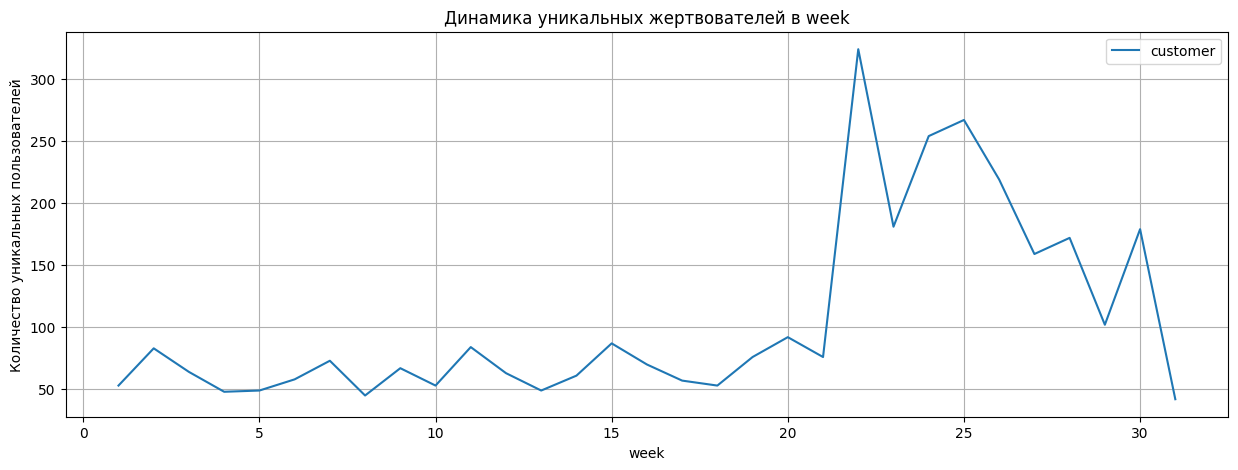

In [197]:
dynamics_plt(completed, 'action_week', 'week')

In [198]:
#sticky factor в процентах по отношению к недельной аудитории

sticky_wau = dau_total / wau_total * 100
sticky_wau

,0
customer,14.263804


In [199]:
#sticky factor в процентах по отношению к месячной аудитории

sticky_wau = dau_total / mau_total * 100
sticky_wau

,0
customer,3.289474


##Сохранение файла

In [200]:
#Сохраним файл excel
completed.to_excel('prostieveschi_completed.xlsx', index=False)

In [201]:
completed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3326 entries, 0 to 3325
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  3326 non-null   object        
 1   action_date         3326 non-null   datetime64[ns]
 2   action_date2        3326 non-null   object        
 3   month               3326 non-null   object        
 4   bank                3326 non-null   object        
 5   site                3326 non-null   object        
 6   order_id            3326 non-null   float64       
 7   customer            3326 non-null   object        
 8   type                3326 non-null   object        
 9   operation_sum       3326 non-null   int64         
 10  operation_currency  3326 non-null   object        
 11  comission_sum       3326 non-null   float64       
 12  final_sum           3326 non-null   float64       
 13  final_currency      3326 non-null   object      

In [202]:
completed.value_counts('segment')

,count
segment,
лояльные,1952
спящие,879
VIP клиенты,362
ушедшие,130
VIP (ушедшие),3


## Вывод

Мы провели предобработку данных:
1.	Заполнили почти все пропуски в столбце **action_date**, за счет информации из других столбцов с датами.
2.	Оценили пропуски в **order_id** и заполнили маркерными значениями
3.	Исключили из анализируемого датафрейма пропуски в столбцах **comission_sum, final_sum и final_curerncy**
4.	Исключили 1 строку с пропуском в поле клиент
5.	Оценили пропуски по столбцу **city**, их оставили
6.	Привели к общему типу значения в поле **status** (отклонена, завершена)
7.	Проверили данные на наличие дубликатов, обнаружили что есть успешные оплаты, проходившие в один день у одного и того же клиента на одинаковую сумму, но это вероятнее всего не дубликаты.  В одном случае возможно клиент проводил отдельными переводами несколько платежей, в другом случае клиент судя по всему оформил три ежемесячные подписки. В случае с отмененными платежами, дубликаты скорей всего связаны с повторными попытками списаний, которые происходят в течение 3х дней. Их мы исключили, также мы исключили транзакции которые в этот же день в итоге завершились успешным списанием.

По результатам RFM анализа у нас получилось 5 сегментов клиентов
1.	**лояльные** - это клиенты, делавшие пожертвования недавно, до 31 день назад, 1-2 перевода в месяц, суммарных переводов до 5000 руб. У этого сегмента в среднем со дня перечисления прошло около 16 дней, средняя частота перечислений месяц 1.4, количество клиентов в этом сегменте 584. Средний чек 470 руб, общая сумма 729 562 р.
2.	**VIP клиенты** - это клиенты, делавшие пожертвования недавно, до 31 день назад, 1-2 перевода в месяц, суммарных переводов от 5000 руб. до 145 200 руб. У этого сегмента в среднем со дня перечисления прошло около 15 дней, средняя частота перечислений месяц 1.2, количество клиентов в этом сегменте 54. Средний чек почти 2900 руб., общая сумма 638 600 р.
3.	**спящие** - это клиенты, делавшие пожертвования относительно давно, 32-91 день назад, 1-2 перевода в месяц, суммарных переводов до 5000 руб. У этого сегмента в среднем со дня перечисления прошло около 53 дней, средняя частота перечислений в месяц 1, количество клиентов в этом сегменте 748. Средний чек 963 руб, общая сумма 851 462 р.
4.	**ушедшие** - это клиенты, делавшие пожертвования давно, более 91 дней назад, суммарных переводов до 5000 руб. У этого сегмента в среднем со дня перечисления прошло около 135 дней, средняя частота перечислений в месяц 1, количество клиентов в этом сегменте 89. Средний чек 867 руб, общая сумма 93 486 р.
5.	**VIP (ушедшие)** - это клиенты, делавшие пожертвования давно, более 91 дней назад, суммарных переводов более 5000 руб. У этого сегмента в среднем со дня перечисления прошло около 135 дней, средняя частота перечислений в месяц 3, количество клиентов в этом сегменте 1. Средний чек 48 400 руб, общая сумма 145 200р.


Можно отметить, что в июне был всплеск по суммарным пожертвованиям, но это были клиенты из сегменты спящие, и поэтому в июле этих платежей мы уже не наблюдаем.

Также можно отметить что к июлю вырос средний чек у сегмента VIP и до июня рос средний чек у сегмента спящие. Средний чек лояльных клиентов почти не вырос. Здесь можно рекомендовать мотивировать клиентов из сегмента лояльные покупать продукцию фонда, для получения дополнительного финансирования из этого сегмента.
Также важная задача переводить спящих клиентов в лояльных


По результатам коготного анализа можно отметить следующее:

**Самые многочисленные когорты – когорты января, мая и июня.**

**Январская когорта** показывает наивысший уровень удержания клиентов, вероятнее всего это постоянные клиенты, отчислявшие деньги и ранее.  Начиная с марта коэффициент удержания сильно падает. **С февраля по апрель** наименьший размер когорт.

**В мае и июне** пришло много новых клиентов и у них достаточно высокая средняя сумма месячных пожертвований на старте в сравнении с январем и февралем.
**За счет своей многочисленности июньская когорта** принесла **наивысшую выручку в первый месяц** и за два месяца она дает суммарную выручку на уровне 6 месяцев 1й когорты.
Мартовская когорта при ясвоей малочисленности дает высокий LTV, это связано с большим платежом от клиента humblehelptope****@gmail.com на сумму 145 200 руб.
Майская когорта вторая по численности и по прибыльности на старте.
